# 0. Attaching libraries

In [559]:
import os
import sqlite3
import pandas as pd
import sys
#from ydata_profiling import ProfileReport # for profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
sns.set_style("whitegrid")       # optional aesthetics
%matplotlib inline 

In [560]:
# Pre-processing & modelling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import joblib

In [561]:
from dateutil.relativedelta import relativedelta
import builtins

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import matplotlib.patches as mpatches

# 1. Reading the core Dataset from the golden source

In [562]:
#csv_file  = "https://raw.githubusercontent.com/mithridata-com/NOVAIMS_BDMwDS_PROJECT/refs/heads/main/00%20Data/Dataset.csv?token=GHSAT0AAAAAADEUY5L7CYN33VQB6LEZUFGK2CIWL5A"
csv_file = r"C:\Users\dimet\Documents\GitHub\NOVAIMS_BDMwDS_PROJECT\00 Data\Dataset.csv"

excel_path  = (r"C:\Users\dimet\Documents\GitHub\NOVAIMS_BDMwDS_PROJECT\02 Output\02 TB Conversion Analytics.xlsx")

In [563]:
# ── Load the CSV into a DataFrame ──────────────────────────────────────────
df = pd.read_csv(csv_file, low_memory=False)

In [564]:
# Quick sanity check (optional)
print(df.shape)       # prints (rows, columns)

(9373, 78)


In [565]:
df.columns

Index(['affinity_name', 'status_report', 'offer_number', 'policy_number',
       'zipcode_link', 'zip4', 'birth_date', 'brand', 'date_offer',
       'date_request', 'policy_start_date', 'premium', 'buildyear_car',
       'buildmonth_car', 'wa', 'wa_bep_ca', 'wa_ca', 'updated_on',
       'policy_continuation_date', 'policy_start_date_pol',
       'policy_lastchange_date', 'premium_wa', 'premium_other',
       'zipcode_link_pol', 'zip4_pol', 'place_residence', 'birth_date_pol',
       'gender', 'private_commercial', 'bonus_malus_percent', 'other_cover',
       'premium_other_incl_discount', 'worth_car', 'brand_pol',
       'builddate_car', 'weight_car', 'mileage_car', 'power_car', 'fuel_car',
       'chassis', 'drive', 'turbo', 'transmission', 'zip4_reg', 'PROVINCE',
       'URB', 'INCOME', 'SOCCL_A', 'SOCCL_B1', 'SOCCL_B2', 'SOCCL_C',
       'SOCCL_D', 'EDU_HIGH', 'EDU_MID', 'EDU_LOW', 'DINK', 'OWN_HOUSE',
       'AVG_HOUSE', 'RENT_PRICE', 'STAGE_OF_LIFE', 'SINGLE', 'FAM',
       'FAM_W

## NEW COLUMNS

In [566]:
df["customer_id"] = df[["zipcode_link", "zip4", "place_residence","birth_date", "gender"]].astype(str).agg("-".join, axis=1)

In [567]:
df['premium_total'] = df['premium_wa'].fillna(0) + df['premium_other'].fillna(0)

In [568]:
df['premium_discount'] = df['premium_other'].fillna(0) - df['premium_other_incl_discount'].fillna(0)

In [569]:
# 1. Build boolean conditions based on == "Y"
conditions = [
    df['wa'] == 'Y',
    df['wa_bep_ca'] == 'Y',
    df['wa_ca'] == 'Y'
]

# 2. Corresponding labels
choices = ['1. Only liability insurance', '2. Liability + limited casco', '3. Liability + full casco']

# 3. Create the new column, defaulting to NaN if none of the three has "Y"
df['coverage_type'] = np.select(conditions, choices, default="")

In [570]:
# ── 1. External “today” reference ───────────────────────────────────────────
current_date = pd.to_datetime("2019-11-01")    # ← use any value you like
fancy_date = current_date.strftime("%B %d %Y")

In [571]:
# ── 2. Parse birth_date & compute age ───────────────────────────────────────
# 2-a. Ensure birth_date is a datetime column
df["birth_date"] = pd.to_datetime(df["birth_date"], errors="coerce")

# 2-b. Convert to integer years using dateutil.relativedelta for accuracy
df["age"] = df["birth_date"].apply(
    lambda bd: relativedelta(current_date, bd).years if pd.notnull(bd) else pd.NA
)
# ── 1. Ensure age is numeric ────────────────────────────────────────────────
# (errors='coerce' converts any bad strings to NaN so they drop out later)
df["age"] = pd.to_numeric(df["age"], errors="coerce")

# ── 2. Create age bands ─────────────────────────────────────────────────────
age_bins   = [0, 25, 35, 45, 55, 65, 120]               # tweak if needed
age_labels = ["<25", "25–34", "35–44", "45–54", "55–64", "65+"]

In [572]:
df["age_band"] = pd.cut(df["age"],
                           bins=age_bins,
                           labels=age_labels,
                           right=False)

In [573]:
df["urb_norm"] = (
    df["URB"]
      .astype(str)
      .str.strip()
      .str[0]                    # first letter
      .str.upper()
      .replace({"1": "1-VeryHigh", "2": "2-High", "3": "3-Mid-to-High", "4": "4-Mid", "5": "5-Mid-to-Low", "6": "6-Low","7": "7-VeryLow", "0": "Unknown", "N" : "Unknown"})
)

In [574]:
month_map = {
    "January":   "01",
    "February":  "02",
    "March":     "03",
    "April":     "04",
    "May":       "05",
    "June":      "06",
    "July":      "07",
    "August":    "08",
    "September": "09",
    "October":   "10",
    "November":  "11",
    "December":  "12"
}

df["buildmonth_num"] = df["buildmonth_car"].map(month_map)

In [575]:
# 2. Combine year + month + “01” (first of month) into a YYYY-MM-DD string and convert to datetime:
df["build_date"] = pd.to_datetime(
    df["buildyear_car"].astype(str).str[:4] + "-" + 
    df["buildmonth_num"] + "-01"
)

# Now 'build_date' holds a Timestamp for the first day of that month/year.
print(df[["buildyear_car", "buildmonth_car", "build_date"]].head())

   buildyear_car buildmonth_car build_date
0         2016.0           June 2016-06-01
1         2015.0           June 2015-06-01
2         2016.0          April 2016-04-01
3         2009.0           June 2009-06-01
4         2003.0        January 2003-01-01


In [576]:
# Calculate car_age
df['car_age'] = current_date.year - df['build_date'].dt.year - (
    (current_date.month < df['build_date'].dt.month) |
    ((current_date.month == df['build_date'].dt.month) & (current_date.day < df['build_date'].dt.day))
).astype(int)

In [577]:
# 1) Make sure `policy_start_date` is a datetime:
df['policy_start_date'] = pd.to_datetime(
    df['policy_start_date'],
    errors='coerce'
)

In [580]:
df

affinity_name           status_report  offer_number  policy_number  \
0           Insuro        Requestwithdrawn          1000        10000.0   
1            other  Tailoredofferwithdrawn          1001            NaN   
2            other       Incompleterequest          1002            NaN   
3            other           Policycreated          1003        10002.0   
4            other           Policycreated          1004        10003.0   
...            ...                     ...           ...            ...   
9368         other         Requestaccepted          9439        11946.0   
9369         other         Waitforapproval          9440        11947.0   
9370        Insuro  Tailoredofferrequested          9441            NaN   
9371           T&B     Calculatenewpremium          9442            NaN   
9372           T&B       Incompleterequest          9443            NaN   

      zipcode_link  zip4 birth_date       brand  date_offer date_request  ...  \
0            10000  2132 1985-01-01     HYUNDAI  2018-10-11   2018-10-11  ...   
1            10001  6027 1987-04-01        AUDI  2018-10-11          NaN  ...   
2            10002  3824 1972-11-01  VOLKSWAGEN  2018-10-11          NaN  ...   
3            10003  6921 1983-08-01       MAZDA  2018-10-11   2018-10-11  ...   
4            10004  8266 1990-04-01       VOLVO  2018-10-12   2018-10-12  ...   
...            ...   ...        ...         ...         ...          ...  ...   
9368         15568  1161 1960-09-01  VOLKSWAGEN  2020-03-08   2020-03-08  ...   
9369         15582  5015 1953-04-01      NISSAN  2020-03-08   2020-03-08  ...   
9370         10332  3078 1976-04-01      TOYOTA  2020-03-08          NaN  ...   
9371         12968  1965 1951-07-01      TOYOTA  2020-03-08          NaN  ...   
9372         15526  1165 1964-01-01       VOLVO  2020-03-08          NaN  ...   

     premium_total  premium_discount                 coverage_type   age  \
0              0.0               0.0   1. Only liability insurance  34.0   
1              0.0               0.0                                32.0   
2              0.0               0.0     3. Liability + full casco  47.0   
3              0.0               0.0  2. Liability + limited casco  36.0   
4              0.0               0.0   1. Only liability insurance  29.0   
...            ...               ...                           ...   ...   
9368           0.0               0.0     3. Liability + full casco  59.0   
9369           0.0               0.0     3. Liability + full casco  66.0   
9370           0.0               0.0  2. Liability + limited casco  43.0   
9371           0.0               0.0  2. Liability + limited casco  68.0   
9372           0.0               0.0     3. Liability + full casco  55.0   

     age_band       urb_norm buildmonth_num build_date car_age car_age_norm  
0       25–34  3-Mid-to-High             06 2016-06-01     3.0          0-3  
1       25–34      7-VeryLow             06 2015-06-01     4.0          4-7  
2       45–54         2-High             04 2016-04-01     3.0          0-3  
3       35–44          4-Mid             06 2009-06-01    10.0         8-11  
4       25–34          4-Mid             01 2003-01-01    16.0          12+  
...       ...            ...            ...        ...     ...          ...  
9368    55–64          6-Low             12 2011-12-01     7.0          4-7  
9369      65+         2-High             02 2017-02-01     2.0          0-3  
9370    35–44     1-VeryHigh             01 2004-01-01    15.0          12+  
9371      65+          4-Mid             09 2004-09-01    15.0          12+  
9372    55–64      7-VeryLow             06 2015-06-01     4.0          4-7  

[9373 rows x 89 columns]

In [581]:
# list of cols to convert
num_cols = ['worth_car', 'weight_car', 'mileage_car', 'power_car']

# coerce to numeric, invalid parsing becomes NaN
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# IMPUTATION

In [582]:
num_cols = [
    'worth_car',
    'weight_car',
    'mileage_car',
    'power_car'
]

cat_cols = [
    'chassis',
    'fuel_car',
    'drive',
    'turbo',
    'transmission'
]


In [583]:
# for each numeric column, fill NAs with the mean _within_ its brand
df[num_cols] = (
    df
    .groupby('brand')[num_cols]
    .transform(lambda col:
        col.fillna(col.mean())    # group-mean imputation
    )
)

In [584]:
def fill_with_mode(series):
    # find the most common value
    modes = series.dropna().mode()
    if len(modes) > 0:
        return series.fillna(modes.iloc[0])
    else:
        return series

df[cat_cols] = (
    df
    .groupby('brand')[cat_cols]
    .transform(fill_with_mode)
)

In [585]:
print(df[num_cols + cat_cols].isna().sum())

worth_car       302
weight_car      302
mileage_car     302
power_car       302
chassis         302
fuel_car        302
drive           302
turbo           302
transmission    302
dtype: int64


In [586]:
mode_income = (
    df
    .groupby('zip4')['INCOME']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    .rename('mode_income')
)

# 2. Merge the mode back into the original DataFrame
df = df.merge(mode_income, left_on='zip4', right_index=True)

# 3. Impute missing INCOME values using the mode for that zip4
df['INCOME_filled'] = df['INCOME'].fillna(df['mode_income'])

# 4. (Optional) Drop the helper column if you no longer need it
df.drop(columns=['mode_income'], inplace=True)

In [587]:
# 2. Second imputation: For any remaining NaNs in INCOME, use PROVINCE-level mode
#    - Compute mode income per PROVINCE based on the “INCOME_imputed_zip4” column
mode_income_prov = (
    df
    .groupby('PROVINCE')['INCOME_filled']
    .agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
    .rename('mode_income_prov')
)

# Merge and fill any remaining NaNs based on province mode
df = df.merge(mode_income_prov, left_on='PROVINCE', right_index=True)
df['INCOME_final'] = df['INCOME_filled'].fillna(df['mode_income_prov'])

# Drop helper columns if desired
df.drop(columns=["INCOME", 'INCOME_filled', 'mode_income_prov'], inplace=True)

## CLUSTERING BY REGION PROFILE

In [588]:
columns_to_keep = [#"PROVINCE",
                   'URB', 'INCOME_final', 'SOCCL_A', 'SOCCL_B1', 'SOCCL_B2', 'SOCCL_C',
                   'SOCCL_D', 'EDU_HIGH', 'EDU_MID', 'EDU_LOW', 'DINK',
                   'OWN_HOUSE', 'AVG_HOUSE',
                   #'age',
                   'SINGLE', 'FAM', 'FAM_WCHILD', 'SINGLES_YOUNG', 'SINGLES_MID', 'SINGLES_OLD', 'FAM_CHILD_Y', 'FAM_CHILD_O', 'FAM_WCHILD_Y', 'FAM_WCHILD_MED','FAM_WCHILD_OLD',
                   'CIT_HOUSEHOLD', 'LOAN', 'SAVINGS', 'SHOP_ONLINE','CAR', # from regional
                   'conv'
                   #'age', 'coverage_type','car_age', # from new columns                  
       ]

In [589]:
#df_sub = df[(df["affinity_name"]=="T&B")&(df["conv"]==1)][columns_to_keep].copy()
df_tb = df[(df["affinity_name"]=="T&B")][columns_to_keep].copy()

In [590]:
df_tb.shape

(3694, 30)

In [591]:
print(df_tb.isna().sum())

URB                0
INCOME_final       0
SOCCL_A           15
SOCCL_B1          15
SOCCL_B2          15
SOCCL_C           15
SOCCL_D           15
EDU_HIGH          15
EDU_MID           15
EDU_LOW           15
DINK              15
OWN_HOUSE         16
AVG_HOUSE         40
SINGLE            15
FAM               15
FAM_WCHILD        15
SINGLES_YOUNG     15
SINGLES_MID       15
SINGLES_OLD       15
FAM_CHILD_Y       15
FAM_CHILD_O       15
FAM_WCHILD_Y      15
FAM_WCHILD_MED    15
FAM_WCHILD_OLD    15
CIT_HOUSEHOLD     15
LOAN              15
SAVINGS           15
SHOP_ONLINE       15
CAR               15
conv               0
dtype: int64


In [592]:
df_tb.dropna(axis=0, how='any', inplace=True)

In [593]:
print(df_tb.isna().sum())

URB               0
INCOME_final      0
SOCCL_A           0
SOCCL_B1          0
SOCCL_B2          0
SOCCL_C           0
SOCCL_D           0
EDU_HIGH          0
EDU_MID           0
EDU_LOW           0
DINK              0
OWN_HOUSE         0
AVG_HOUSE         0
SINGLE            0
FAM               0
FAM_WCHILD        0
SINGLES_YOUNG     0
SINGLES_MID       0
SINGLES_OLD       0
FAM_CHILD_Y       0
FAM_CHILD_O       0
FAM_WCHILD_Y      0
FAM_WCHILD_MED    0
FAM_WCHILD_OLD    0
CIT_HOUSEHOLD     0
LOAN              0
SAVINGS           0
SHOP_ONLINE       0
CAR               0
conv              0
dtype: int64


In [594]:
df_tb[columns_to_keep[1:]].corr()

INCOME_final   SOCCL_A  SOCCL_B1  SOCCL_B2   SOCCL_C  \
INCOME_final        1.000000 -0.421167 -0.211338  0.125147  0.326162   
SOCCL_A            -0.421167  1.000000  0.076337 -0.564669 -0.535601   
SOCCL_B1           -0.211338  0.076337  1.000000 -0.091165 -0.511949   
SOCCL_B2            0.125147 -0.564669 -0.091165  1.000000  0.150354   
SOCCL_C             0.326162 -0.535601 -0.511949  0.150354  1.000000   
SOCCL_D             0.421325 -0.486430 -0.501999 -0.041809  0.425852   
EDU_HIGH           -0.419384  0.910176  0.102304 -0.507901 -0.516838   
EDU_MID            -0.090023 -0.208244  0.648350  0.187500 -0.166048   
EDU_LOW             0.453942 -0.689096 -0.496034  0.371408  0.590347   
DINK               -0.361932  0.512512  0.502509 -0.201451 -0.563319   
OWN_HOUSE          -0.363583  0.564287  0.534302 -0.273021 -0.594775   
AVG_HOUSE          -0.319629  0.698455  0.303423 -0.344152 -0.552543   
SINGLE              0.282035 -0.517877 -0.370742  0.254990  0.501583   
FAM                -0.153203  0.200712  0.158526  0.012648 -0.200539   
FAM_WCHILD         -0.215017  0.383970  0.447592 -0.151359 -0.467924   
SINGLES_YOUNG       0.115581 -0.173134 -0.250855  0.065150  0.342855   
SINGLES_MID         0.107050 -0.292503 -0.179766  0.215561  0.325934   
SINGLES_OLD         0.284683 -0.437714 -0.258644  0.184276  0.325935   
FAM_CHILD_Y        -0.026204 -0.002113  0.070358  0.074891 -0.009179   
FAM_CHILD_O        -0.141421  0.250218  0.184729 -0.049538 -0.273144   
FAM_WCHILD_Y       -0.049722 -0.008296  0.105755  0.099989 -0.045871   
FAM_WCHILD_MED     -0.115800  0.208098  0.252382 -0.096234 -0.233295   
FAM_WCHILD_OLD     -0.160233  0.297407  0.382196 -0.132814 -0.397478   
CIT_HOUSEHOLD      -0.177223  0.283781  0.235280 -0.055434 -0.327550   
LOAN               -0.066365 -0.222912 -0.028095  0.288997  0.147017   
SAVINGS            -0.397322  0.564561  0.453426 -0.230174 -0.522651   
SHOP_ONLINE        -0.440664  0.547274  0.503909 -0.144074 -0.581647   
CAR                -0.298200  0.418713  0.482640 -0.136840 -0.545952   
conv                0.018475 -0.035699 -0.058988  0.024636  0.050904   

                 SOCCL_D  EDU_HIGH   EDU_MID   EDU_LOW      DINK  ...  \
INCOME_final    0.421325 -0.419384 -0.090023  0.453942 -0.361932  ...   
SOCCL_A        -0.486430  0.910176 -0.208244 -0.689096  0.512512  ...   
SOCCL_B1       -0.501999  0.102304  0.648350 -0.496034  0.502509  ...   
SOCCL_B2       -0.041809 -0.507901  0.187500  0.371408 -0.201451  ...   
SOCCL_C         0.425852 -0.516838 -0.166048  0.590347 -0.563319  ...   
SOCCL_D         1.000000 -0.490887 -0.350879  0.688399 -0.550091  ...   
EDU_HIGH       -0.490887  1.000000 -0.244734 -0.698846  0.461520  ...   
EDU_MID        -0.350879 -0.244734  1.000000 -0.422237  0.260040  ...   
EDU_LOW         0.688399 -0.698846 -0.422237  1.000000 -0.573135  ...   
DINK           -0.550091  0.461520  0.260040 -0.573135  1.000000  ...   
OWN_HOUSE      -0.573741  0.518942  0.241534 -0.601040  0.685336  ...   
AVG_HOUSE      -0.542020  0.625822  0.002917 -0.571001  0.538362  ...   
SINGLE          0.460035 -0.441512 -0.108364  0.464007 -0.694144  ...   
FAM            -0.250334  0.132547  0.051720 -0.139270  0.614647  ...   
FAM_WCHILD     -0.462158  0.347555  0.191737 -0.412129  0.389652  ...   
SINGLES_YOUNG   0.142155 -0.091288  0.019222  0.029679 -0.323612  ...   
SINGLES_MID     0.125807 -0.253448  0.041068  0.196104 -0.350174  ...   
SINGLES_OLD     0.452244 -0.414950 -0.178897  0.529685 -0.546841  ...   
FAM_CHILD_Y    -0.109587 -0.025876  0.107009 -0.040739  0.360807  ...   
FAM_CHILD_O    -0.241870  0.180596  0.018040 -0.149581  0.500422  ...   
FAM_WCHILD_Y   -0.154729  0.044764  0.153910 -0.156620  0.154917  ...   
FAM_WCHILD_MED -0.268364  0.191456  0.154863 -0.273201  0.378267  ...   
FAM_WCHILD_OLD -0.327843  0.244250  0.122791 -0.258049  0.233007  ...   
CIT_HOUSEHOLD  -0.309634  0.207537  0.049391 -0.209174  0.646876  ...   
LOAN           -0.038533 -0.18

In [595]:
df_tb = df_tb.drop(columns = ["SOCCL_A"])

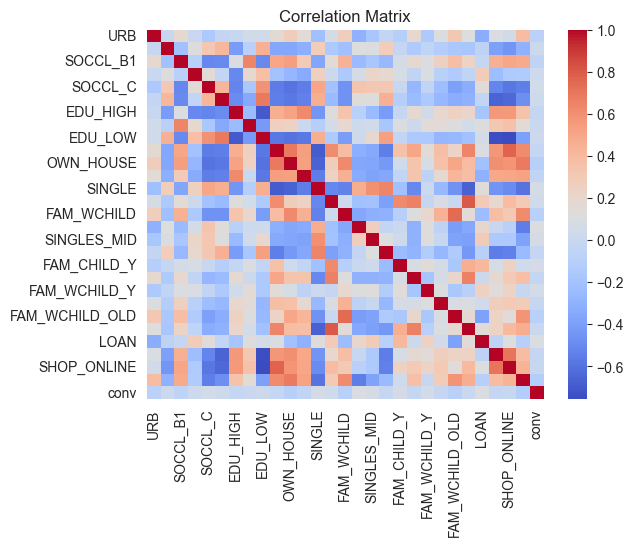

In [596]:
numeric_cols = df_tb.select_dtypes(include='number').columns
corr = df_tb[numeric_cols].corr()
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# CLUSTERING

In [597]:
df_sub = df_tb[df_tb["conv"]==1].copy()

In [598]:
df_sub = df_sub.drop(columns = ["conv"])

In [599]:
df_sub_clean = df_sub.dropna()  # or use imputation if many missing

In [600]:
categorical_cols = df_sub.select_dtypes(include='object').columns
df_sub_encoded = pd.get_dummies(df_sub_clean, columns=categorical_cols, drop_first=True)

In [601]:
X = df_sub_encoded.select_dtypes(include='number')
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

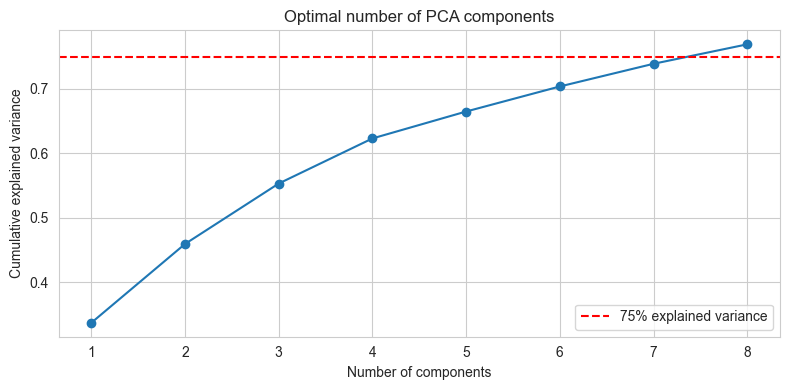

Optimal number of PCA components: 1


In [604]:
pca = PCA(n_components = 8)
X_pca = pca.fit_transform(X_scaled)

# Cumulative explained variance
cum_var = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8,4))
plt.plot(range(1, len(cum_var)+1), cum_var, marker='o')
plt.axhline(0.75, color='r', linestyle='--', label='75% explained variance')
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.title('Optimal number of PCA components')
plt.legend()
plt.tight_layout()
plt.show()

# Select number of components where cum_var > desired threshold (e.g., 0.9)
n_components = np.argmax(cum_var >= 0.9) + 1
print(f"Optimal number of PCA components: {n_components}")

In [605]:
components = pca.components_
clustering_feature_cols = df_sub.columns.tolist()
n_top = 5
top_features = {}

for i, comp in enumerate(components[0:15]):
    indices = np.argsort(np.abs(comp))[::-1][:n_top]
    top_features[f'PC{i+1}'] = [(clustering_feature_cols[idx], comp[idx]) for idx in indices]

# Optionally convert to DataFrame for easy viewing
rows = []
for pc, feats in top_features.items():
    for feat, weight in feats:
        rows.append({'PC': pc, 'Feature': feat, 'Loading': weight})
        

In [606]:
df_pca_loadings = pd.DataFrame(rows)

In [607]:
print(df_pca_loadings)

     PC         Feature   Loading
0   PC1            DINK  0.283016
1   PC1       OWN_HOUSE  0.272181
2   PC1     SHOP_ONLINE  0.257914
3   PC1          SINGLE -0.255646
4   PC1             CAR  0.253581
5   PC2   CIT_HOUSEHOLD  0.366763
6   PC2             FAM  0.357688
7   PC2     FAM_CHILD_O  0.331113
8   PC2         EDU_LOW  0.320553
9   PC2   SINGLES_YOUNG -0.276626
10  PC3            LOAN  0.446702
11  PC3     FAM_CHILD_Y  0.399770
12  PC3             URB -0.311551
13  PC3  FAM_WCHILD_OLD -0.302231
14  PC3             FAM  0.289314
15  PC4         EDU_MID  0.458470
16  PC4        SOCCL_B2  0.419664
17  PC4        EDU_HIGH -0.401862
18  PC4        SOCCL_B1  0.299500
19  PC4    FAM_WCHILD_Y  0.240819
20  PC5    FAM_WCHILD_Y  0.448175
21  PC5      FAM_WCHILD  0.410403
22  PC5         EDU_MID -0.381186
23  PC5  FAM_WCHILD_MED  0.345315
24  PC5        SOCCL_B1 -0.233056
25  PC6  FAM_WCHILD_MED  0.417169
26  PC6    INCOME_final  0.362645
27  PC6     SINGLES_OLD -0.355819
28  PC6       

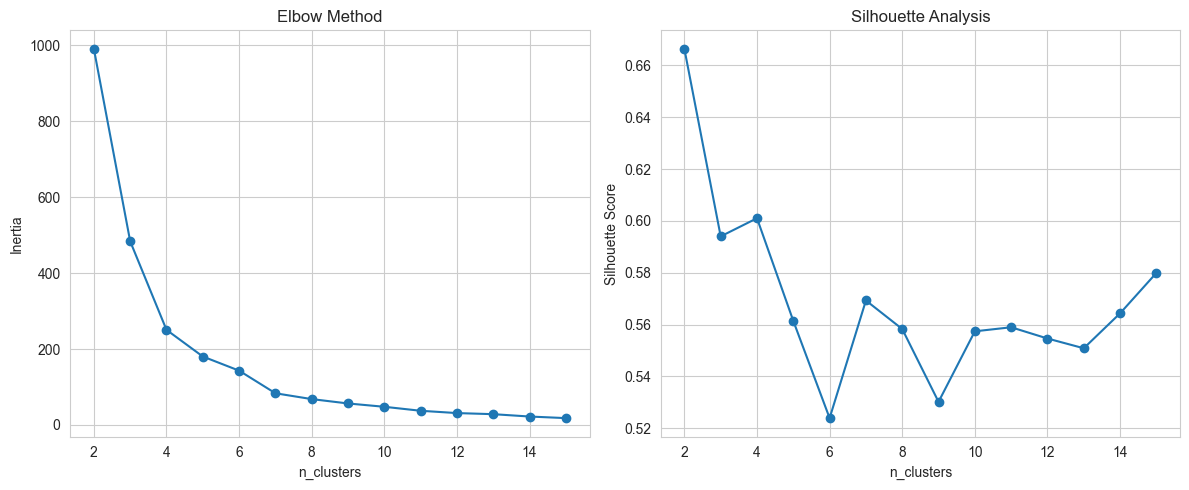

Optimal number of clusters by silhouette: 2


In [608]:
sil_scores = []
inertias = []
K = range(2, 16)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1)
    labels = kmeans.fit_predict(X_pca[:, :n_components])  # use reduced data
    sil = silhouette_score(X_pca[:, :n_components], labels)
    sil_scores.append(sil)
    inertias.append(kmeans.inertia_)
    

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K, inertias, marker='o')
plt.xlabel('n_clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1,2,2)
plt.plot(K, sil_scores, marker='o')
plt.xlabel('n_clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis')
plt.tight_layout()
plt.show()

# Optionally, print best k by silhouette
best_k = K[np.argmax(sil_scores)]
print(f"Optimal number of clusters by silhouette: {best_k}")


In [609]:
sil_matrix = np.zeros((15, 15))  # 10 components x 10 clusters example

for nc in range(2, 16):
    pca_cycle = PCA(n_components=nc)
    X_pc = pca_cycle.fit_transform(X_scaled)
    for k in range(2, 16):
        kmeans = KMeans(n_clusters=k, random_state=1)
        labels = kmeans.fit_predict(X_pc)
        sil = silhouette_score(X_pc, labels)
        sil_matrix[nc-1, k-1] = sil

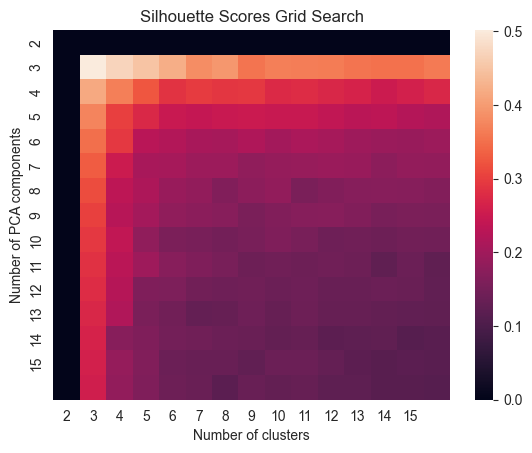

In [610]:
sns.heatmap(sil_matrix, xticklabels=range(2,16), yticklabels=range(2,16))
plt.xlabel('Number of clusters')
plt.ylabel('Number of PCA components')
plt.title('Silhouette Scores Grid Search')
plt.show()

In [611]:
kmeans_pca = KMeans(n_clusters=4, random_state=1)
labels_pca = kmeans_pca.fit_predict(X_pca)
score_pca = silhouette_score(X_pca, labels_pca)
print(f'Silhouette score with PCA: {score_pca:.3f}')

Silhouette score with PCA: 0.204


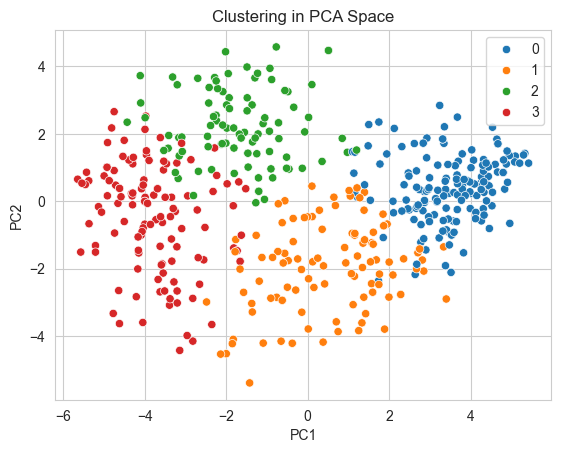

In [612]:
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_pca, palette='tab10')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('Clustering in PCA Space')
plt.show()

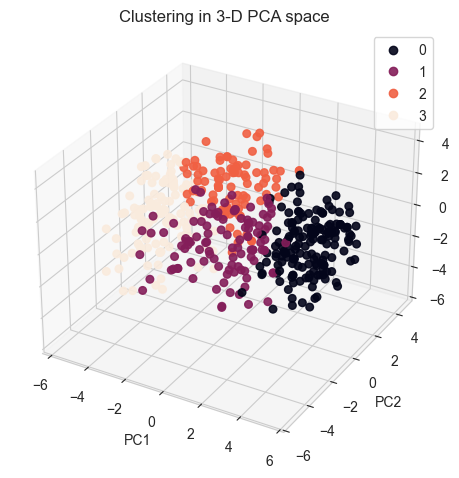

In [613]:
# --- 1. Imports --------------------------------------------------------------
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # registers the 3-D projection

# --- 2. Create a 3-D scatter plot -------------------------------------------
fig = plt.figure()
ax  = fig.add_subplot(111, projection="3d")

# If labels_pca is already numeric (0,1,2,…), you can pass it directly
# Otherwise, encode to integers beforehand (e.g., with sklearn's LabelEncoder).
scatter = ax.scatter(
    X_pca[:, 0],          # PC1  ➜ x-axis
    X_pca[:, 1],          # PC2  ➜ y-axis
    X_pca[:, 2],          # PC3  ➜ z-axis
    c=labels_pca,         # colour by cluster/label
    s=30,                 # marker size (adjust as you like)
    alpha=0.9,            # a touch of transparency helps when points overlap
)

# --- 3. Cosmetic touches -----------------------------------------------------
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Clustering in 3-D PCA space")

# A neat categorical legend:
legend_handles, legend_labels = scatter.legend_elements(prop="colors")
ax.legend(legend_handles, legend_labels)

# If you want a particular viewing angle:
# ax.view_init(elev=15, azim=135)   # elevation°, azimuth°  (tweak to taste)

plt.tight_layout()
plt.show()


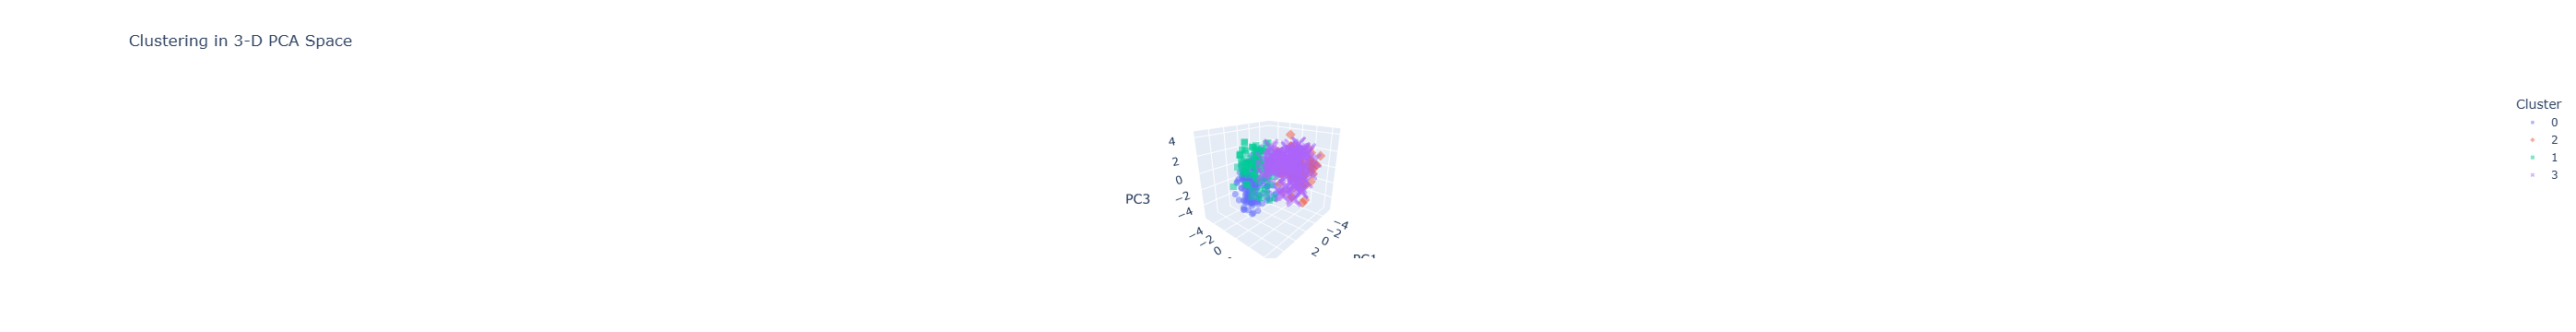

In [614]:
# ── 1. Imports ────────────────────────────────────────────────────────────────
import pandas as pd
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objs as go

pyo.init_notebook_mode()

# ── 2. Package PCA data into a tidy DataFrame ────────────────────────────────
df_pca = pd.DataFrame({
    "PC1":   X_pca[:, 0],
    "PC2":   X_pca[:, 1],
    "PC3":   X_pca[:, 2],      # your “pca02” axis
    "label": labels_pca.astype(str)  # cast to str ⇒ discrete colour scale
})

# ── 3. Build the interactive 3-D scatter plot ────────────────────────────────
fig = px.scatter_3d(
    df_pca,
    x="PC1",  y="PC2",  z="PC3",
    color="label",            # cluster colouring
    symbol="label",           # optional: different markers per cluster
    opacity=0.5,
    title="Clustering in 3-D PCA Space",
    labels=dict(PC1="PC1", PC2="PC2", PC3="PC3"),
    hover_data=df_pca.columns  # everything shows up on hover
)

# ── 4. Cosmetic tweaks (optional) ────────────────────────────────────────────
fig.update_traces(marker=dict(size=4))          # shrink points if dense
fig.update_layout(legend_title_text="Cluster")  # tidy legend title
fig.update_layout(scene_camera=dict(
    eye=dict(x=1.5, y=1.3, z=0.8)               # starting viewpoint
))

# ── 5. Show (Jupyter, VS Code, etc.) ─────────────────────────────────────────
#fig.show()

In [615]:
#fig.write_html("3D_plot_PCA.html")

In [616]:
os.getcwd()

'C:\\Users\\dimet\\Documents\\GitHub\\NOVAIMS_BDMwDS_PROJECT\\01 Code'

In [617]:
# Adjust the range if you used a different number of components
pc_columns = [f'PC{i+1}' for i in range(X_pca.shape[1])]

df_pca = pd.DataFrame(X_pca, columns=pc_columns)
df_pca['cluster'] = labels_pca.astype(str)  # Convert to string for color-coding

In [618]:
df_pca

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0    3.195165  1.068259 -0.076336 -1.347991 -1.338159  0.285699  0.003825   
1    4.878790  1.101507 -0.633620 -1.618504 -0.486108 -0.080980 -0.901616   
2    3.828669 -1.533097 -2.617079  0.547690  0.185831  1.704874 -1.838731   
3    4.007439  0.226030  1.133480  1.473137 -0.186729 -0.216980 -0.837386   
4   -2.119389  1.689285  1.186758  0.149084  1.935284 -0.447876 -0.233791   
..        ...       ...       ...       ...       ...       ...       ...   
482  1.850659 -0.386226  2.234053  2.314147  1.654540  0.748453 -0.886293   
483 -4.280664  1.299539  0.186096 -0.554171  1.611597  0.735984 -0.472147   
484  1.212073  0.392497 -0.076612  0.808465 -1.359983 -1.365676  0.869515   
485  4.672648  1.702448  0.382852 -0.984798 -1.951501  0.316003 -0.672502   
486  2.312899  1.616866 -2.011982  1.475121 -0.420974  0.607650  0.519939   

          PC8 cluster  
0    0.715907       0  
1    0.010248       0  
2    0.224569       0  
3    0.031095       0  
4   -1.982445       2  
..        ...     ...  
482  0.100906       1  
483 -0.068580       3  
484  0.362987       1  
485 -0.624796       0  
486  0.523825       0  

[487 rows x 9 columns]

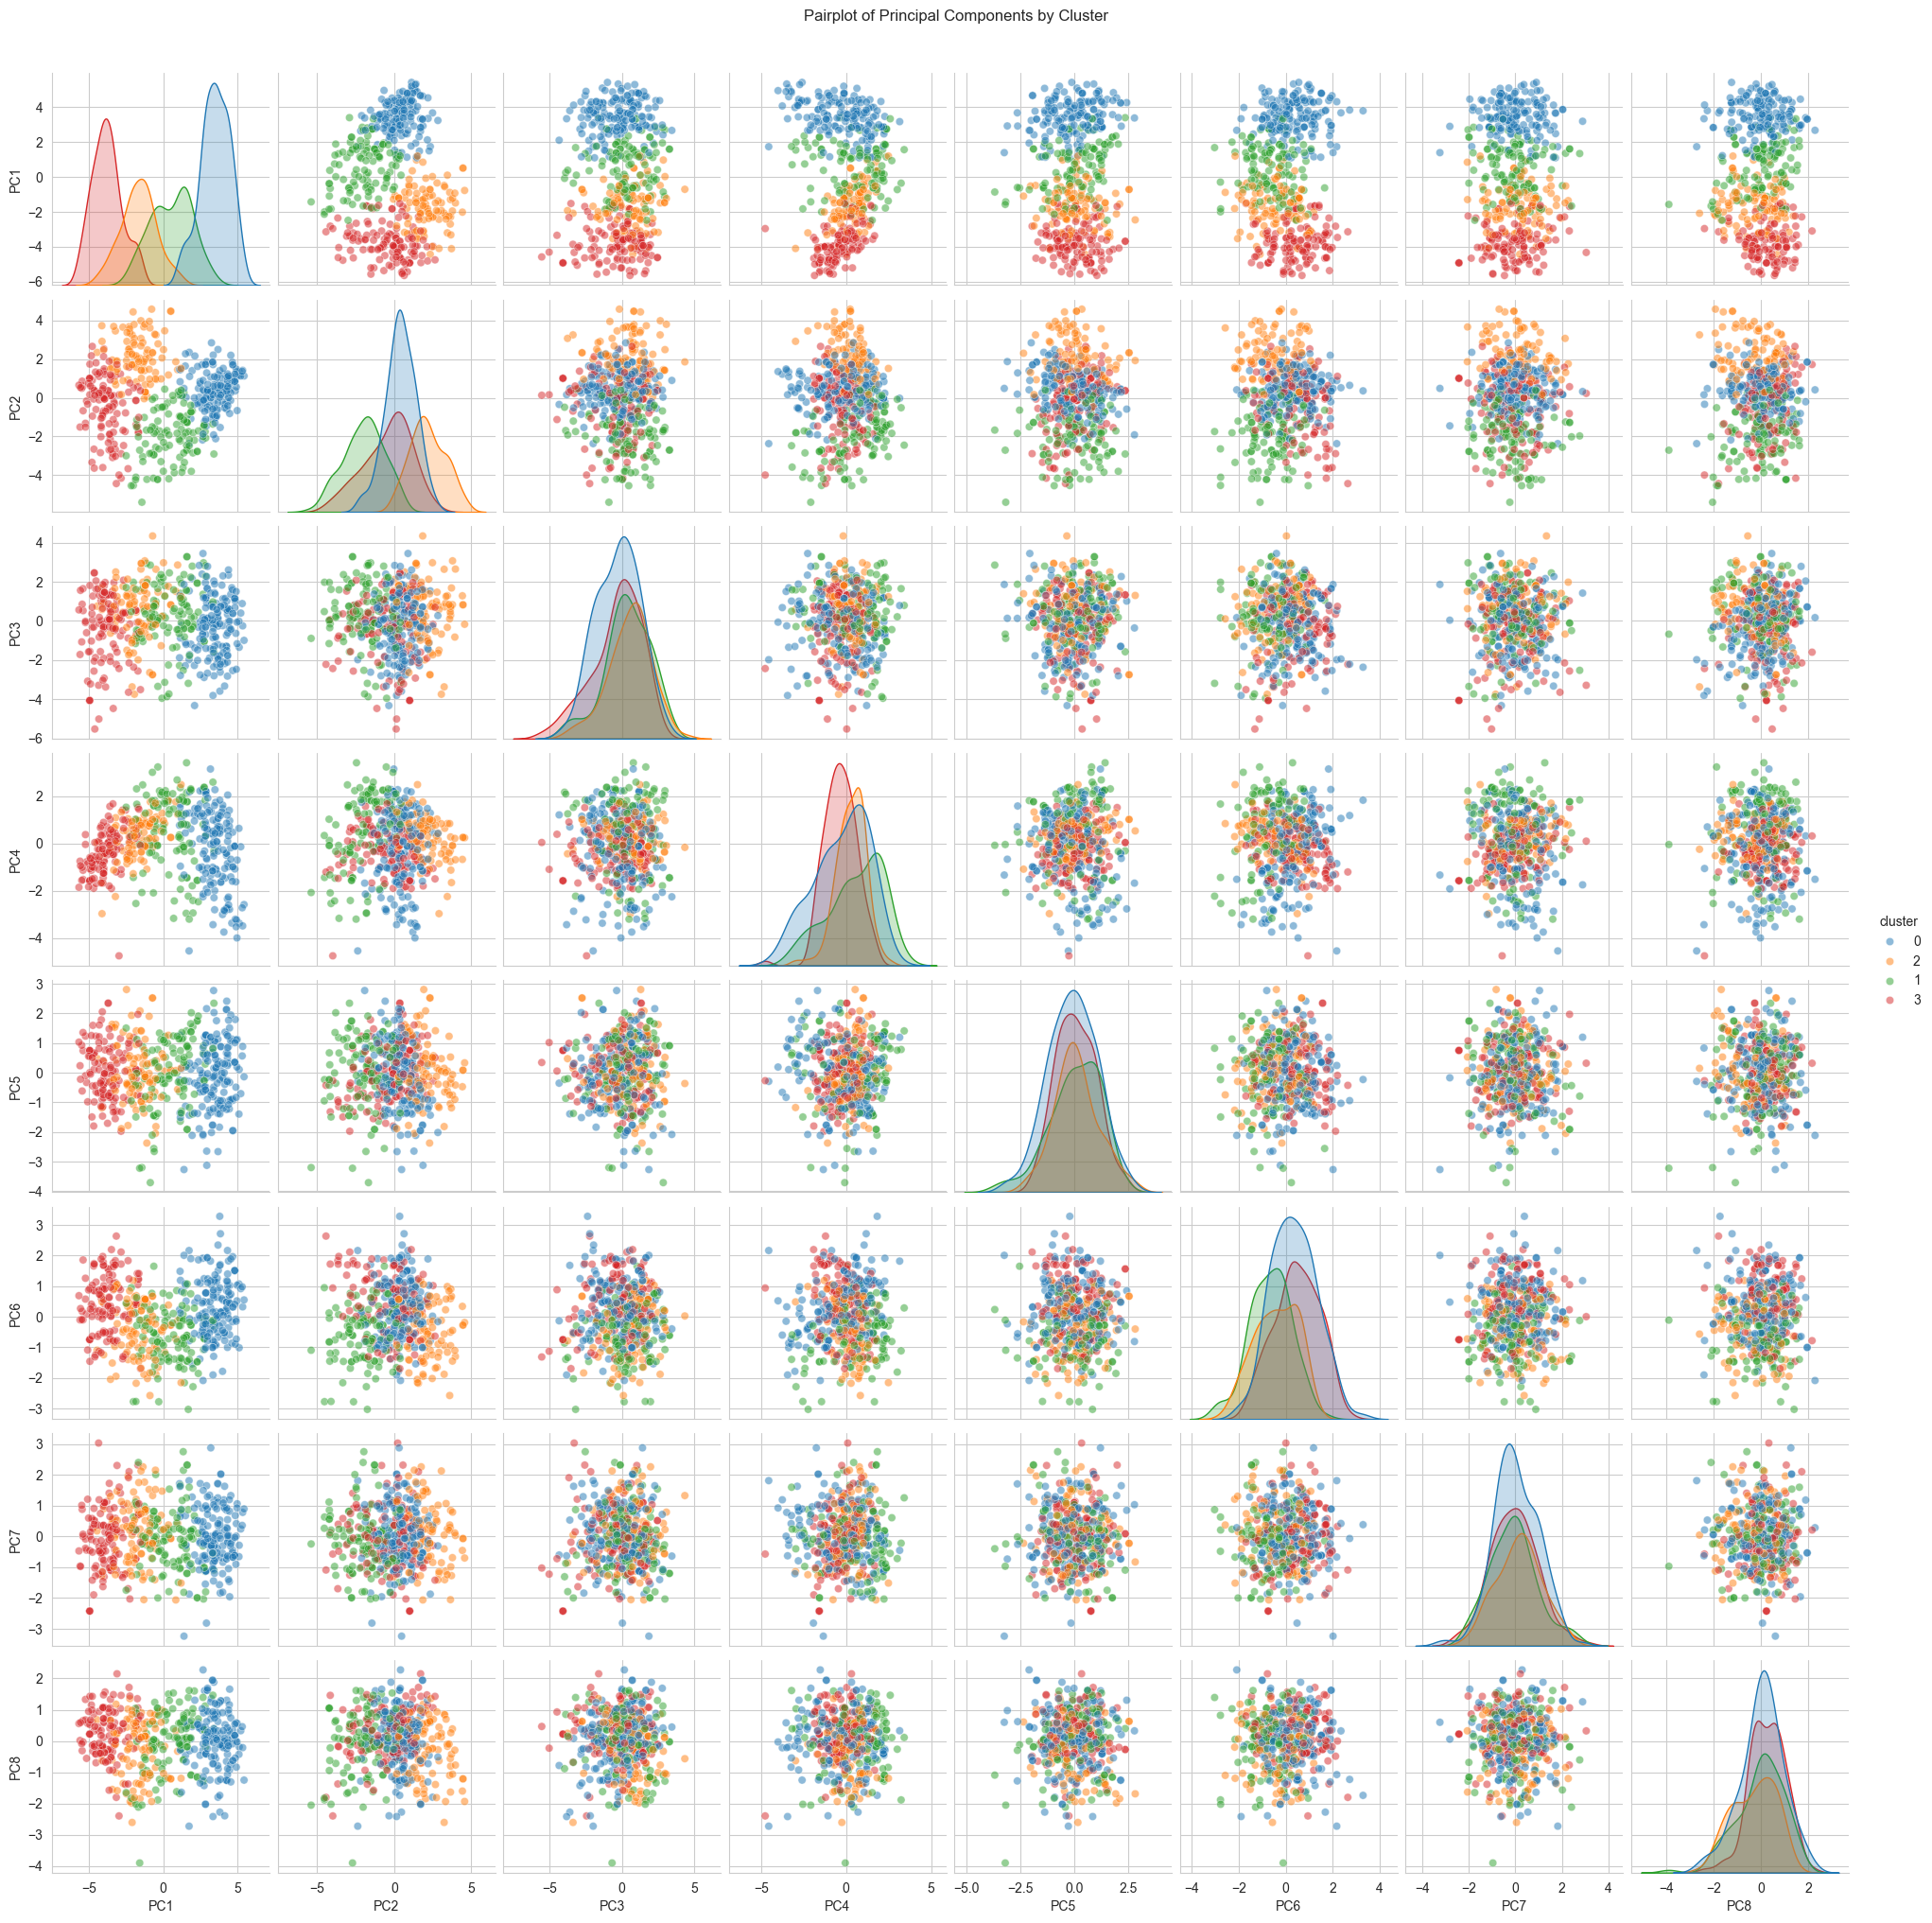

In [619]:
sns.pairplot(
    df_pca, 
    vars=pc_columns,         # All PC columns
    hue='cluster',           # Color by cluster
    palette='tab10',         # Nice color scheme
    plot_kws={'alpha': 0.5}  # Transparency for overlap
)
plt.suptitle('Pairplot of Principal Components by Cluster', y=1.02)
plt.show()

In [620]:
df_pca.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  3.195165  1.068259 -0.076336 -1.347991 -1.338159  0.285699  0.003825   
1  4.878790  1.101507 -0.633620 -1.618504 -0.486108 -0.080980 -0.901616   
2  3.828669 -1.533097 -2.617079  0.547690  0.185831  1.704874 -1.838731   
3  4.007439  0.226030  1.133480  1.473137 -0.186729 -0.216980 -0.837386   
4 -2.119389  1.689285  1.186758  0.149084  1.935284 -0.447876 -0.233791   

        PC8 cluster  
0  0.715907       0  
1  0.010248       0  
2  0.224569       0  
3  0.031095       0  
4 -1.982445       2

In [621]:
df_sub.head()

URB  INCOME_final  SOCCL_B1  SOCCL_B2  SOCCL_C  SOCCL_D  EDU_HIGH  \
952   7.0           2.0       3.0       2.0      2.0      1.0       4.0   
1109  2.0           2.0       3.0       1.0      1.0      1.0       4.0   
1120  4.0           2.0       4.0       1.0      1.0      1.0       2.0   
1220  2.0           2.0       4.0       2.0      1.0      1.0       2.0   
1237  2.0           4.0       1.0       3.0      3.0      2.0       2.0   

      EDU_MID  EDU_LOW  DINK  ...  FAM_CHILD_Y  FAM_CHILD_O  FAM_WCHILD_Y  \
952       3.0      2.0   5.0  ...          4.0          3.0           1.0   
1109      3.0      2.0   6.0  ...          3.0          4.0           1.0   
1120      5.0      1.0   4.0  ...          3.0          1.0           1.0   
1220      5.0      2.0   6.0  ...          3.0          4.0           3.0   
1237      2.0      4.0   2.0  ...          3.0          4.0           4.0   

      FAM_WCHILD_MED  FAM_WCHILD_OLD  CIT_HOUSEHOLD  LOAN  SAVINGS  \
952              1.0             3.0            5.0   1.0      4.0   
1109             2.0             4.0            5.0   2.0      6.0   
1120             3.0             4.0            3.0   1.0      5.0   
1220             2.0             3.0            5.0   4.0      5.0   
1237             1.0             1.0            4.0   3.0      2.0   

      SHOP_ONLINE  CAR  
952           6.0  5.0  
1109          6.0  5.0  
1120          4.0  5.0  
1220          6.0  5.0  
1237          2.0  2.0  

[5 rows x 28 columns]

In [622]:
labels_pca.shape

(487,)

In [623]:
df_tb.head()

URB  INCOME_final  SOCCL_B1  SOCCL_B2  SOCCL_C  SOCCL_D  EDU_HIGH  \
787  5.0           2.0       4.0       2.0      1.0      2.0       3.0   
873  4.0           6.0       3.0       3.0      1.0      1.0       1.0   
952  7.0           2.0       3.0       2.0      2.0      1.0       4.0   
953  7.0           2.0       3.0       2.0      2.0      1.0       4.0   
954  7.0           2.0       3.0       2.0      2.0      1.0       4.0   

     EDU_MID  EDU_LOW  DINK  ...  FAM_CHILD_O  FAM_WCHILD_Y  FAM_WCHILD_MED  \
787      4.0      2.0   6.0  ...          3.0           1.0             3.0   
873      5.0      2.0   3.0  ...          2.0           1.0             2.0   
952      3.0      2.0   5.0  ...          3.0           1.0             1.0   
953      3.0      2.0   5.0  ...          3.0           1.0             1.0   
954      3.0      2.0   5.0  ...          3.0           1.0             1.0   

     FAM_WCHILD_OLD  CIT_HOUSEHOLD  LOAN  SAVINGS  SHOP_ONLINE  CAR  conv  
787             4.0            5.0   1.0      5.0          6.0  5.0     0  
873             4.0            4.0   2.0      5.0          3.0  3.0     0  
952             3.0            5.0   1.0      4.0          6.0  5.0     1  
953             3.0            5.0   1.0      4.0          6.0  5.0     0  
954             3.0            5.0   1.0      4.0          6.0  5.0     0  

[5 rows x 29 columns]

# MODELLING

In [624]:
joblib.dump(scaler,  'scaler.pkl')
joblib.dump(pca,     'pca.pkl')
joblib.dump(kmeans_pca,  'kmeans_pca.pkl')

['kmeans_pca.pkl']

In [625]:
feat_cols = df_sub.columns

In [626]:
X_tb = df_tb.copy()          # raises if a col is missing → healthier

X_tb = X_tb.reindex(columns=feat_cols)

In [627]:
X_tb

URB  INCOME_final  SOCCL_B1  SOCCL_B2  SOCCL_C  SOCCL_D  EDU_HIGH  \
787   5.0           2.0       4.0       2.0      1.0      2.0       3.0   
873   4.0           6.0       3.0       3.0      1.0      1.0       1.0   
952   7.0           2.0       3.0       2.0      2.0      1.0       4.0   
953   7.0           2.0       3.0       2.0      2.0      1.0       4.0   
954   7.0           2.0       3.0       2.0      2.0      1.0       4.0   
...   ...           ...       ...       ...      ...      ...       ...   
9364  6.0           3.0       4.0       2.0      2.0      2.0       2.0   
9366  4.0           1.0       1.0       1.0      1.0      1.0       5.0   
9367  2.0           4.0       3.0       3.0      2.0      3.0       1.0   
9371  4.0           2.0       4.0       1.0      2.0      1.0       3.0   
9372  7.0           2.0       4.0       2.0      1.0      1.0       2.0   

      EDU_MID  EDU_LOW  DINK  ...  FAM_CHILD_Y  FAM_CHILD_O  FAM_WCHILD_Y  \
787       4.0      2.0   6.0  ...          4.0          3.0           1.0   
873       5.0      2.0   3.0  ...          3.0          2.0           1.0   
952       3.0      2.0   5.0  ...          4.0          3.0           1.0   
953       3.0      2.0   5.0  ...          4.0          3.0           1.0   
954       3.0      2.0   5.0  ...          4.0          3.0           1.0   
...       ...      ...   ...  ...          ...          ...           ...   
9364      5.0      2.0   5.0  ...          3.0          2.0           3.0   
9366      1.0      1.0   6.0  ...          3.0          4.0           1.0   
9367      4.0      3.0   4.0  ...          3.0          3.0           1.0   
9371      4.0      1.0   2.0  ...          1.0          3.0           1.0   
9372      4.0      2.0   4.0  ...          2.0          4.0           1.0   

      FAM_WCHILD_MED  FAM_WCHILD_OLD  CIT_HOUSEHOLD  LOAN  SAVINGS  \
787              3.0             4.0            5.0   1.0      5.0   
873              2.0             4.0            4.0   2.0      5.0   
952              1.0             3.0            5.0   1.0      4.0   
953              1.0             3.0            5.0   1.0      4.0   
954              1.0             3.0            5.0   1.0      4.0   
...              ...             ...            ...   ...      ...   
9364             2.0             3.0            3.0   4.0      6.0   
9366             3.0             3.0            6.0   2.0      6.0   
9367             3.0             2.0            4.0   4.0      4.0   
9371             3.0             4.0            3.0   2.0      3.0   
9372             1.0             4.0            5.0   3.0      5.0   

      SHOP_ONLINE  CAR  
787           6.0  5.0  
873           3.0  3.0  
952           6.0  5.0  
953           6.0  5.0  
954           6.0  5.0  
...           ...  ...  
9364          6.0  5.0  
9366          6.0  5.0  
9367          4.0  5.0  
9371          3.0  5.0  
9372          5.0  5.0  

[3654 rows x 28 columns]

In [628]:
# load objects -----------------------------------------------------------
scaler  = joblib.load('scaler.pkl')
pca     = joblib.load('pca.pkl')
kmeans_pca_model  = joblib.load('kmeans_pca.pkl')

# 1. feature matrix ------------------------------------------------------
X_tb = df_tb[feat_cols].copy()

# 2. identical preprocessing --------------------------------------------
X_scaled = scaler.transform(X_tb)          # **do NOT refit** the scaler!

# 3. project to PC space -------------------------------------------------
X_pc     = pca.transform(X_scaled)         # shape: (3654, 8)

In [629]:
X_scaled

array([[ 0.87337054, -0.92793654,  1.61484694, ...,  0.52586502,
         1.03079896,  1.02719393],
       [ 0.35719159,  2.2377734 ,  0.6928886 , ...,  0.52586502,
        -0.62961701, -0.26542479],
       [ 1.90572845, -0.92793654,  0.6928886 , ..., -0.13932008,
         1.03079896,  1.02719393],
       ...,
       [-0.67516631,  0.65491843,  0.6928886 , ..., -0.13932008,
        -0.07614502,  1.02719393],
       [ 0.35719159, -0.92793654,  1.61484694, ..., -0.80450519,
        -0.62961701,  1.02719393],
       [ 1.90572845, -0.92793654,  1.61484694, ...,  0.52586502,
         0.47732697,  1.02719393]], shape=(3654, 28))

In [630]:
# 4. assign clusters -----------------------------------------------------
df_tb['cluster'] = kmeans_pca_model.predict(X_pc)

In [631]:
df_tb['cluster'].value_counts()

cluster
0    1528
1     754
3     720
2     652
Name: count, dtype: int64

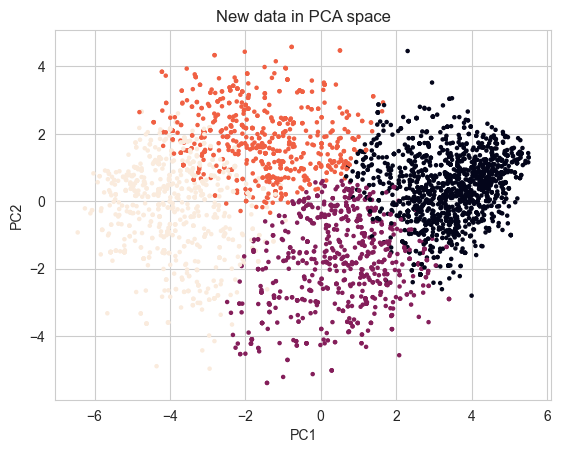

In [632]:
plt.scatter(X_pc[:,0], X_pc[:,1], c=df_tb['cluster'], s=5)
plt.xlabel('PC1'); plt.ylabel('PC2'); plt.title('New data in PCA space')
plt.show()

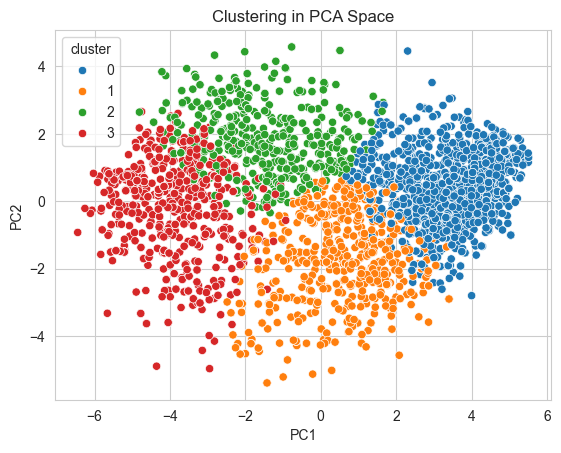

In [633]:
sns.scatterplot(x=X_pc[:,0], y=X_pc[:,1], hue=df_tb['cluster'], palette='tab10')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('Clustering in PCA Space')
plt.show()

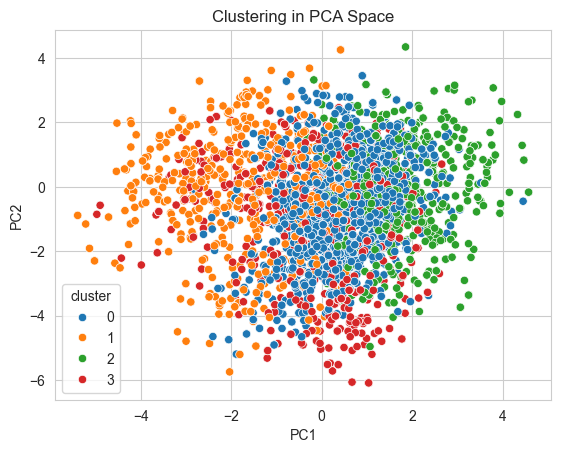

In [634]:
sns.scatterplot(x=X_pc[:,1], y=X_pc[:,2], hue=df_tb['cluster'], palette='tab10')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.title('Clustering in PCA Space')
plt.show()

C:\Users\dimet\AppData\Local\Temp\ipykernel_5824\1591617553.py:11: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



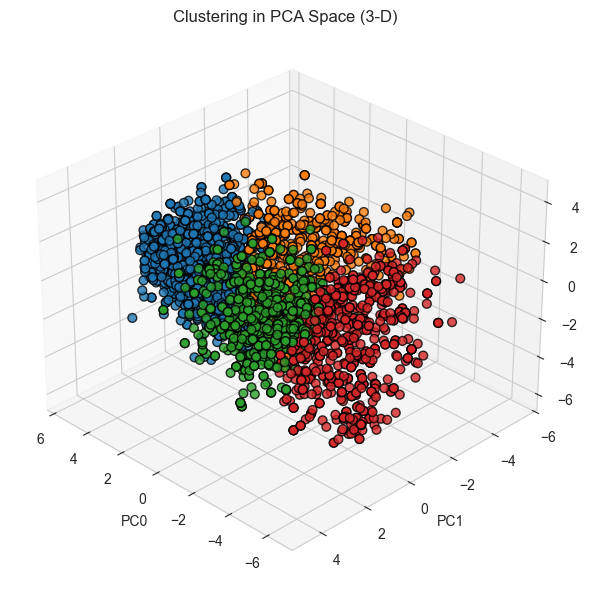

In [635]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 – needed for 3-D projection
from matplotlib.cm import get_cmap

# ------------- data assumed to be ready -------------
# X_pc  : numpy array with at least 3 principal-component columns
# df_tb : DataFrame containing a column 'cluster' with integer labels
# ----------------------------------------------------

# Map clusters to the same 'tab10' colors you used in seaborn
cmap    = get_cmap('tab10')
colors  = df_tb['cluster'].map(lambda c: cmap(int(c)))

# Create 3-D scatter plot
fig = plt.figure(figsize=(8, 6))
ax  = fig.add_subplot(111, projection='3d')

ax.scatter(
    X_pc[:, 0],           # PC0  (1st component)
    X_pc[:, 1],           # PC1  (2nd component)
    X_pc[:, 2],           # PC2  (3rd component)
    c=list(colors),       # list(...) -- Matplotlib expects a sequence
    s=40,                 # point size
    edgecolor='k',
    alpha=0.8
)

# Axis labels and title
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
ax.set_zlabel('PC2')
ax.set_title('Clustering in PCA Space (3-D)')

# Optional: tweak the initial view
ax.view_init(elev=30, azim=135)

plt.tight_layout()
plt.show()


In [636]:
# 1. How many centroids did the stored model have?
print("k =", kmeans_pca.n_clusters)                # e.g. 8

# 2. Which labels occurred in the TRAINING run?
train_labels = np.unique(kmeans_pca.labels_)
print("labels seen during fit:", train_labels) # e.g. [0 1 2 4 5 6 7] -> centroid 3 was empty

# 3. Which labels turn up in the NEW data?
new_labels = np.unique(kmeans_pca_model.predict(X_pc))
print("labels seen in df_tb:", new_labels)     # e.g. [0 1 2 3 4 5 6 7]


k = 4
labels seen during fit: [0 1 2 3]
labels seen in df_tb: [0 1 2 3]


In [637]:
# make sure df_tb already has the 'cluster' column you created earlier
# -------------------------------------------------------------------

pivot_conv_clusters = (df_tb
                       .groupby('conv')['cluster']          # group by the conversion flag
                       .unique()                           # keep only distinct cluster labels
                       .apply(lambda arr: sorted(arr))     # (optional) sort the list of labels
                       .reset_index(name='clusters'))      # tidy DataFrame shape

pivot_conv_clusters


conv      clusters
0     0  [0, 1, 2, 3]
1     1  [0, 1, 2, 3]

In [638]:
# ── 1. conversion rate + row count per cluster ───────────────────────
conv_rate_by_cluster = (
    df_tb
      .groupby('cluster')                       # one row per cluster
      .agg(
          conv_rate=('conv', 'mean'),           # average conversion rate
          n_rows   =('conv', 'size')            # number of rows / customers
      )
      .reset_index()                            # tidy two-column index
)

conv_rate_by_cluster


cluster  conv_rate  n_rows
0        0   0.106021    1528
1        1   0.143236     754
2        2   0.144172     652
3        3   0.170833     720

In [639]:
df_tb

URB  INCOME_final  SOCCL_B1  SOCCL_B2  SOCCL_C  SOCCL_D  EDU_HIGH  \
787   5.0           2.0       4.0       2.0      1.0      2.0       3.0   
873   4.0           6.0       3.0       3.0      1.0      1.0       1.0   
952   7.0           2.0       3.0       2.0      2.0      1.0       4.0   
953   7.0           2.0       3.0       2.0      2.0      1.0       4.0   
954   7.0           2.0       3.0       2.0      2.0      1.0       4.0   
...   ...           ...       ...       ...      ...      ...       ...   
9364  6.0           3.0       4.0       2.0      2.0      2.0       2.0   
9366  4.0           1.0       1.0       1.0      1.0      1.0       5.0   
9367  2.0           4.0       3.0       3.0      2.0      3.0       1.0   
9371  4.0           2.0       4.0       1.0      2.0      1.0       3.0   
9372  7.0           2.0       4.0       2.0      1.0      1.0       2.0   

      EDU_MID  EDU_LOW  DINK  ...  FAM_WCHILD_Y  FAM_WCHILD_MED  \
787       4.0      2.0   6.0  ...           1.0             3.0   
873       5.0      2.0   3.0  ...           1.0             2.0   
952       3.0      2.0   5.0  ...           1.0             1.0   
953       3.0      2.0   5.0  ...           1.0             1.0   
954       3.0      2.0   5.0  ...           1.0             1.0   
...       ...      ...   ...  ...           ...             ...   
9364      5.0      2.0   5.0  ...           3.0             2.0   
9366      1.0      1.0   6.0  ...           1.0             3.0   
9367      4.0      3.0   4.0  ...           1.0             3.0   
9371      4.0      1.0   2.0  ...           1.0             3.0   
9372      4.0      2.0   4.0  ...           1.0             1.0   

      FAM_WCHILD_OLD  CIT_HOUSEHOLD  LOAN  SAVINGS  SHOP_ONLINE  CAR  conv  \
787              4.0            5.0   1.0      5.0          6.0  5.0     0   
873              4.0            4.0   2.0      5.0          3.0  3.0     0   
952              3.0            5.0   1.0      4.0          6.0  5.0     1   
953              3.0            5.0   1.0      4.0          6.0  5.0     0   
954              3.0            5.0   1.0      4.0          6.0  5.0     0   
...              ...            ...   ...      ...          ...  ...   ...   
9364             3.0            3.0   4.0      6.0          6.0  5.0     0   
9366             3.0            6.0   2.0      6.0          6.0  5.0     0   
9367             2.0            4.0   4.0      4.0          4.0  5.0     0   
9371             4.0            3.0   2.0      3.0          3.0  5.0     0   
9372             4.0            5.0   3.0      5.0          5.0  5.0     0   

      cluster  
787         0  
873         1  
952         0  
953         0  
954         0  
...       ...  
9364        1  
9366        0  
9367        2  
9371        0  
9372        0  

[3654 rows x 30 columns]

# AUTO DATA CLUSTERING

In [640]:
df.columns

Index(['affinity_name', 'status_report', 'offer_number', 'policy_number',
       'zipcode_link', 'zip4', 'birth_date', 'brand', 'date_offer',
       'date_request', 'policy_start_date', 'premium', 'buildyear_car',
       'buildmonth_car', 'wa', 'wa_bep_ca', 'wa_ca', 'updated_on',
       'policy_continuation_date', 'policy_start_date_pol',
       'policy_lastchange_date', 'premium_wa', 'premium_other',
       'zipcode_link_pol', 'zip4_pol', 'place_residence', 'birth_date_pol',
       'gender', 'private_commercial', 'bonus_malus_percent', 'other_cover',
       'premium_other_incl_discount', 'worth_car', 'brand_pol',
       'builddate_car', 'weight_car', 'mileage_car', 'power_car', 'fuel_car',
       'chassis', 'drive', 'turbo', 'transmission', 'zip4_reg', 'PROVINCE',
       'URB', 'SOCCL_A', 'SOCCL_B1', 'SOCCL_B2', 'SOCCL_C', 'SOCCL_D',
       'EDU_HIGH', 'EDU_MID', 'EDU_LOW', 'DINK', 'OWN_HOUSE', 'AVG_HOUSE',
       'RENT_PRICE', 'STAGE_OF_LIFE', 'SINGLE', 'FAM', 'FAM_WCHILD',
       'S

In [643]:
columns_to_keep_cars = ['conv',
                        "brand",
                        'weight_car', 'mileage_car', 'power_car', 'fuel_car',
                        #'chassis', 'drive', 'turbo', 'transmission'                
       ]


In [644]:
#df_sub = df[(df["affinity_name"]=="T&B")&(df["conv"]==1)][columns_to_keep].copy()
df_cars = df[(df["affinity_name"]=="T&B")][columns_to_keep_cars].copy()

In [645]:
df_cars

conv          brand   weight_car  mileage_car   power_car  fuel_car
787      0     ALFA ROMEO  1211.250000    11.250000   88.250000    DIESEL
873      0  MERCEDES-BENZ  1365.375000    15.000000   99.500000    DIESEL
952      1        RENAULT   839.000000    15.000000   55.000000  GASOLINE
953      0        RENAULT  1001.909091    14.750000   62.045455  GASOLINE
954      0        CITROEN  1023.266667    15.666667   61.600000  GASOLINE
...    ...            ...          ...          ...         ...       ...
9364     0     VOLKSWAGEN  1080.200000    15.000000   68.266667  GASOLINE
9366     0            BMW  1450.555556    15.000000  133.222222  GASOLINE
9367     0         SUZUKI   858.333333    14.444444   57.555556  GASOLINE
9371     0         TOYOTA   830.800000    13.000000   53.800000  GASOLINE
9372     0          VOLVO  1427.000000    15.000000  110.400000  GASOLINE

[3694 rows x 6 columns]

In [646]:
df_cars.describe()

conv   weight_car  mileage_car    power_car
count  3694.000000  3593.000000  3593.000000  3593.000000
mean      0.134001  1052.744766    14.582569    68.380219
std       0.340700   180.216638     1.064085    21.296315
min       0.000000   695.000000    10.000000    33.000000
25%       0.000000   955.962963    14.444444    55.200000
50%       0.000000  1005.562500    15.000000    62.045455
75%       0.000000  1080.200000    15.000000    68.266667
max       1.000000  2320.000000    20.000000   261.000000

In [647]:
print(df_cars.isna().sum())

conv             0
brand            0
weight_car     101
mileage_car    101
power_car      101
fuel_car       101
dtype: int64


In [648]:
df_cars.dropna(axis=0, how='any', inplace=True)

In [649]:
print(df_cars.isna().sum())

conv           0
brand          0
weight_car     0
mileage_car    0
power_car      0
fuel_car       0
dtype: int64


In [650]:
df_cars["brand"].value_counts()

brand
VOLKSWAGEN       466
OPEL             343
PEUGEOT          308
RENAULT          265
FORD             251
TOYOTA           231
CITROEN          159
BMW              153
FIAT             136
MERCEDES-BENZ    128
SEAT             118
VOLVO            113
AUDI             113
SUZUKI           112
HYUNDAI          107
KIA              104
NISSAN            93
MAZDA             75
SKODA             63
MITSUBISHI        48
DAIHATSU          36
HONDA             34
CHEVROLET         30
MINI              21
ALFA ROMEO        19
DAEWOO            19
SUBARU            16
SMART             11
LAND ROVER        11
LEXUS              5
ROVER              5
Name: count, dtype: int64

In [652]:
import pandas as pd

# assume df_cars has columns:
#   brand,
#   weight_car, mileage_car, power_car, fuel_car   (numeric)
#   chassis, drive, turbo, transmission           (categorical)

# 1.1 Numeric summaries per brand
num_agg = (
    df_cars
      .groupby('brand')[['weight_car','mileage_car','power_car']]
      .agg(['mean','std','min','max'])
)
# flatten the MultiIndex
num_agg.columns = ['_'.join(col) for col in num_agg.columns]
# e.g. weight_car_mean, weight_car_std, …

# 1.2 Categorical proportions per brand
cat_cols = ['fuel_car']
cat_dfs = []
for col in cat_cols:
    # get dummies and group‐sum, then divide by total cars per brand
    dummies = pd.get_dummies(df_cars[[ 'brand', col ]].set_index('brand')[col], prefix=col)
    prop = (
        dummies
          .groupby(level=0)
          .sum()
          .div( dummies.groupby(level=0).sum().sum(axis=1), axis=0 )
    )
    cat_dfs.append(prop)
    
cat_agg = pd.concat(cat_dfs, axis=1)

# 1.3 Combined brand‐features
brand_features = pd.concat([num_agg, cat_agg], axis=1).fillna(0)


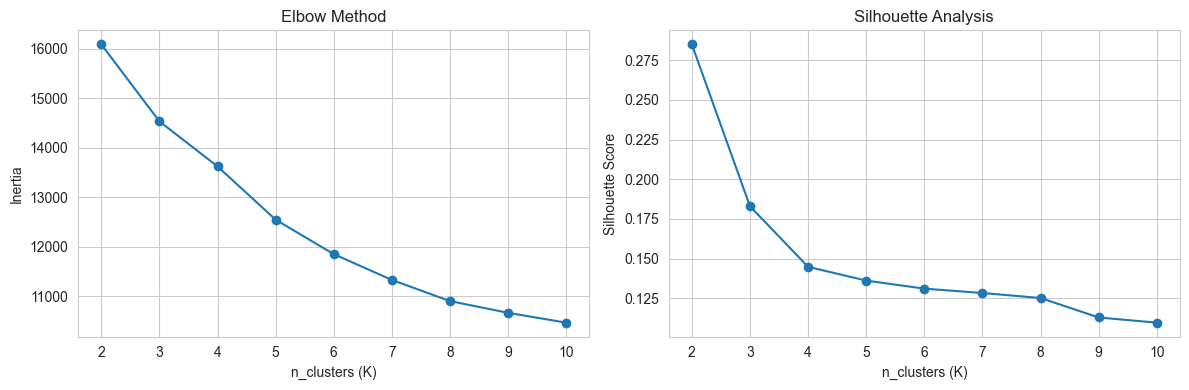

In [653]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# — assume X is your (n_brands × n_features) array —

ks = range(2, 11)
inertias = []
sil_scores = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=1)
    labels = km.fit_predict(X)
    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X, labels))

# — plot both metrics side by side —
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Elbow plot (inertia vs K)
axes[0].plot(ks, inertias, '-o')
axes[0].set_xlabel('n_clusters (K)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')

# Silhouette plot (score vs K)
axes[1].plot(ks, sil_scores, '-o')
axes[1].set_xlabel('n_clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis')

plt.tight_layout()
plt.show()


In [654]:
brand_features

weight_car_mean  weight_car_std  weight_car_min  \
brand                                                            
ALFA ROMEO         1211.250000       42.143109          1125.0   
AUDI               1335.000000       11.970947          1295.0   
BMW                1450.555556       77.839757          1225.0   
CHEVROLET           828.000000       45.767780           750.0   
CITROEN            1023.266667       51.787231           805.0   
DAEWOO              775.000000        0.000000           775.0   
DAIHATSU            695.000000        0.000000           695.0   
FIAT                917.500000       40.812353           710.0   
FORD                985.500000       23.150724           862.0   
HONDA              1099.000000       41.604924           930.0   
HYUNDAI             939.500000        9.990089           880.0   
KIA                 941.000000       39.053610           815.0   
LAND ROVER         1702.000000        0.000000          1702.0   
LEXUS              1535.000000        0.000000          1535.0   
MAZDA              1171.666667       23.312410          1010.0   
MERCEDES-BENZ      1365.375000       40.252928          1063.0   
MINI                997.500000       18.183097           940.0   
MITSUBISHI         1218.333333      101.254542           925.0   
NISSAN              971.750000       38.242184           780.0   
OPEL               1014.904762       37.880306           842.0   
PEUGEOT             955.962963       48.813778           775.0   
RENAULT            1001.909091       41.380158           795.0   
ROVER              1345.000000        0.000000          1345.0   
SEAT               1005.562500       42.840186           839.0   
SKODA              1211.000000       39.654963          1065.0   
SMART               695.000000        0.000000           695.0   
SUBARU             1415.000000        0.000000          1415.0   
SUZUKI              858.333333       27.353212           705.0   
TOYOTA              830.800000       12.549519           754.0   
VOLKSWAGEN         1080.200000       42.094701           803.0   
VOLVO              1427.000000       21.533197          1336.0   

               weight_car_max  mileage_car_mean  mileage_car_std  \
brand                                                              
ALFA ROMEO             1360.0         11.250000         1.020621   
AUDI                   1440.0         15.000000         0.000000   
BMW                    2320.0         15.000000         0.811107   
CHEVROLET              1041.0         15.000000         0.000000   
CITROEN                1395.0         15.666667         0.523700   
DAEWOO                  775.0         10.000000         0.000000   
DAIHATSU                695.0         17.500000         0.597614   
FIAT                   1120.0         13.500000         0.871355   
FORD                   1216.0         15.000000         0.447214   
HONDA                  1268.0         15.000000         1.230915   
HYUNDAI                1006.0         15.000000         0.000000   
KIA                    1284.0         13.750000         0.426660   
LAND ROVER             1702.0         15.000000         0.000000   
LEXUS                  1535.0         15.000000         0.000000   
MAZDA                  1275.0         15.000000         0.000000   
MERCEDES-BENZ          1650.0         15.000000         0.000000   
MINI                   1055.0         15.000000         0.000000   
MITSUBISHI             1785.0         16.666667         0.595491   
NISSAN                 1225.0         15.000000         0.737210   
OPEL                   1405.0         14.761905         0.712892   
PEUGEOT                1209.0         13.518519         0.885535   
RENAULT                1283.0         14.750000         0.684653   
ROVER                  1345.0         15.000000         0.000000   
SEAT                   1285.0         14.642857         0.445435   
SKODA                  1465.0         13.333333         0.518476   


In [655]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 2A.1 Scale
scaler = StandardScaler()
X = scaler.fit_transform(brand_features)

# 2A.2 Pick K via silhouette or elbow
sil_scores = []
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=1).fit(X)
    sil = silhouette_score(X, km.labels_)
    sil_scores.append((k, sil))
# inspect sil_scores to choose the best k

In [656]:
sil_scores

[(2, np.float64(0.30585031354999237)),
 (3, np.float64(0.3049000552432773)),
 (4, np.float64(0.22373735328542246)),
 (5, np.float64(0.26995023782265465)),
 (6, np.float64(0.2838690657430274)),
 (7, np.float64(0.3114179753457759))]

In [657]:
# Suppose we pick k=4
kmeans = KMeans(n_clusters=6, random_state=1).fit(X)
brand_features['cluster_kmeans'] = kmeans.labels_

In [658]:
import prince

# 2B.1 Prepare raw brand‐level data: reset index
bf = brand_features.reset_index()

# but prince.FAMD wants raw categorical columns, so we need to rebuild brand-level
# by taking the modal category per brand for each cat‐col:
modal = df_cars.groupby('brand')[cat_cols].agg(lambda s: s.mode().iat[0])
bf = bf.merge(modal, on='brand')

# separate: 
num_feats = [c for c in bf.columns if any(n in c for n in ['_mean','_std','_min','_max'])]
cat_feats = cat_cols

# 2B.2 Run FAMD
famd = prince.FAMD(
    n_components=3,
    n_iter=3,
    copy=True,
    random_state=1
).fit(bf[num_feats + cat_feats])

X_famd = famd.row_coordinates(bf)

# 2B.3 Cluster on FAMD coords
kmeans_famd = KMeans(n_clusters=4, random_state=1).fit(X_famd)
bf['cluster_famd'] = kmeans_famd.labels_

# put it back into brand_features
brand_features['cluster_famd'] = bf.set_index('brand')['cluster_famd']

In [659]:
# view cluster assignments
print(brand_features[['cluster_kmeans','cluster_famd']])

# if you want each car to know its brand‐cluster:
df_cars = df_cars.merge(
    brand_features[['cluster_kmeans','cluster_famd']],
    left_on='brand', right_index=True
)


               cluster_kmeans  cluster_famd
brand                                      
ALFA ROMEO                  5             1
AUDI                        0             0
BMW                         2             2
CHEVROLET                   3             3
CITROEN                     1             1
DAEWOO                      3             3
DAIHATSU                    3             3
FIAT                        1             1
FORD                        1             1
HONDA                       1             1
HYUNDAI                     3             3
KIA                         1             1
LAND ROVER                  0             0
LEXUS                       4             0
MAZDA                       4             0
MERCEDES-BENZ               0             0
MINI                        3             3
MITSUBISHI                  1             1
NISSAN                      1             1
OPEL                        1             1
PEUGEOT                     1   

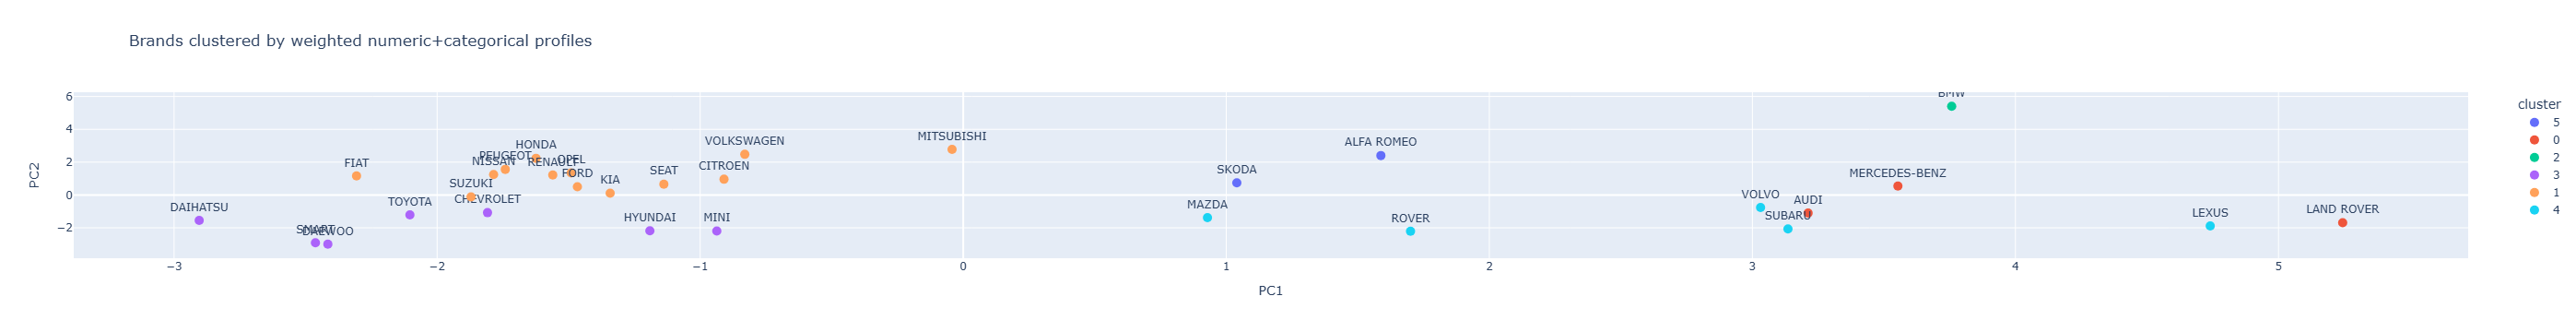

In [660]:
from sklearn.decomposition import PCA
import plotly.express as px

# reduce to 2D for viz
pca = PCA(n_components=2, random_state=1)
coords = pca.fit_transform(scaler.fit_transform(brand_features.drop(columns=['cluster_kmeans','cluster_famd'])))
viz_df = pd.DataFrame(coords, columns=['PC1','PC2'], index=brand_features.index)
viz_df['cluster'] = brand_features['cluster_kmeans'].astype(str)

fig = px.scatter(
    viz_df.reset_index(),
    x='PC1', y='PC2', text='brand',
    color='cluster',
    title='Brands clustered by weighted numeric+categorical profiles'
)
fig.update_traces(textposition='top center', marker=dict(size=10))
fig.show()


In [661]:
df_cars

conv          brand   weight_car  mileage_car   power_car  fuel_car  \
787      0     ALFA ROMEO  1211.250000    11.250000   88.250000    DIESEL   
873      0  MERCEDES-BENZ  1365.375000    15.000000   99.500000    DIESEL   
952      1        RENAULT   839.000000    15.000000   55.000000  GASOLINE   
953      0        RENAULT  1001.909091    14.750000   62.045455  GASOLINE   
954      0        CITROEN  1023.266667    15.666667   61.600000  GASOLINE   
...    ...            ...          ...          ...         ...       ...   
9364     0     VOLKSWAGEN  1080.200000    15.000000   68.266667  GASOLINE   
9366     0            BMW  1450.555556    15.000000  133.222222  GASOLINE   
9367     0         SUZUKI   858.333333    14.444444   57.555556  GASOLINE   
9371     0         TOYOTA   830.800000    13.000000   53.800000  GASOLINE   
9372     0          VOLVO  1427.000000    15.000000  110.400000  GASOLINE   

      cluster_kmeans  cluster_famd  
787                5             1  
873                0             0  
952                1             1  
953                1             1  
954                1             1  
...              ...           ...  
9364               1             1  
9366               2             2  
9367               1             1  
9371               3             3  
9372               4             0  

[3593 rows x 8 columns]

In [662]:
# ── 1. conversion rate + row count per cluster ───────────────────────
conv_rate_by_cluster_cars = (
    df_cars
      .groupby('cluster_kmeans')                       # one row per cluster
      .agg(
          conv_rate=('conv', 'mean'),           # average conversion rate
          n_rows   =('conv', 'size')            # number of rows / customers
      )
      .reset_index()                            # tidy two-column index
)

conv_rate_by_cluster_cars


cluster_kmeans  conv_rate  n_rows
0               0   0.123016     252
1               1   0.146081    2437
2               2   0.137255     153
3               3   0.105495     455
4               4   0.098131     214
5               5   0.146341      82

In [663]:
df_cars

conv          brand   weight_car  mileage_car   power_car  fuel_car  \
787      0     ALFA ROMEO  1211.250000    11.250000   88.250000    DIESEL   
873      0  MERCEDES-BENZ  1365.375000    15.000000   99.500000    DIESEL   
952      1        RENAULT   839.000000    15.000000   55.000000  GASOLINE   
953      0        RENAULT  1001.909091    14.750000   62.045455  GASOLINE   
954      0        CITROEN  1023.266667    15.666667   61.600000  GASOLINE   
...    ...            ...          ...          ...         ...       ...   
9364     0     VOLKSWAGEN  1080.200000    15.000000   68.266667  GASOLINE   
9366     0            BMW  1450.555556    15.000000  133.222222  GASOLINE   
9367     0         SUZUKI   858.333333    14.444444   57.555556  GASOLINE   
9371     0         TOYOTA   830.800000    13.000000   53.800000  GASOLINE   
9372     0          VOLVO  1427.000000    15.000000  110.400000  GASOLINE   

      cluster_kmeans  cluster_famd  
787                5             1  
873                0             0  
952                1             1  
953                1             1  
954                1             1  
...              ...           ...  
9364               1             1  
9366               2             2  
9367               1             1  
9371               3             3  
9372               4             0  

[3593 rows x 8 columns]

In [664]:
# Pivot: only the mean of conv → conv_rate
conv_rate_pivot = pd.pivot_table(
    df_cars,
    values='conv',
    index='brand',
    columns='cluster_kmeans',
    aggfunc='mean',
    fill_value=0
)

In [665]:
conv_rate_pivot

cluster_kmeans         0         1         2         3         4         5
brand                                                                     
ALFA ROMEO      0.000000  0.000000  0.000000  0.000000  0.000000  0.210526
AUDI            0.150442  0.000000  0.000000  0.000000  0.000000  0.000000
BMW             0.000000  0.000000  0.137255  0.000000  0.000000  0.000000
CHEVROLET       0.000000  0.000000  0.000000  0.266667  0.000000  0.000000
CITROEN         0.000000  0.169811  0.000000  0.000000  0.000000  0.000000
DAEWOO          0.000000  0.000000  0.000000  0.157895  0.000000  0.000000
DAIHATSU        0.000000  0.000000  0.000000  0.138889  0.000000  0.000000
FIAT            0.000000  0.147059  0.000000  0.000000  0.000000  0.000000
FORD            0.000000  0.111554  0.000000  0.000000  0.000000  0.000000
HONDA           0.000000  0.058824  0.000000  0.000000  0.000000  0.000000
HYUNDAI         0.000000  0.000000  0.000000  0.093458  0.000000  0.000000
KIA             0.000000  0.096154  0.000000  0.000000  0.000000  0.000000
LAND ROVER      0.090909  0.000000  0.000000  0.000000  0.000000  0.000000
LEXUS           0.000000  0.000000  0.000000  0.000000  0.200000  0.000000
MAZDA           0.000000  0.000000  0.000000  0.000000  0.066667  0.000000
MERCEDES-BENZ   0.101562  0.000000  0.000000  0.000000  0.000000  0.000000
MINI            0.000000  0.000000  0.000000  0.142857  0.000000  0.000000
MITSUBISHI      0.000000  0.083333  0.000000  0.000000  0.000000  0.000000
NISSAN          0.000000  0.107527  0.000000  0.000000  0.000000  0.000000
OPEL            0.000000  0.142857  0.000000  0.000000  0.000000  0.000000
PEUGEOT         0.000000  0.152597  0.000000  0.000000  0.000000  0.000000
RENAULT         0.000000  0.147170  0.000000  0.000000  0.000000  0.000000
ROVER           0.000000  0.000000  0.000000  0.000000  0.200000  0.000000
SEAT            0.000000  0.245763  0.000000  0.000000  0.000000  0.000000
SKODA           0.000000  0.000000  0.000000  0.000000  0.000000  0.126984
SMART           0.000000  0.000000  0.000000  0.272727  0.000000  0.000000
SUBARU          0.000000  0.000000  0.000000  0.000000  0.062500  0.000000
SUZUKI          0.000000  0.142857  0.000000  0.000000  0.000000  0.000000
TOYOTA          0.000000  0.000000  0.000000  0.069264  0.000000  0.000000
VOLKSWAGEN      0.000000  0.160944  0.000000  0.000000  0.000000  0.000000
VOLVO           0.000000  0.000000  0.000000  0.000000  0.115044  0.000000

In [666]:
# 1) Extract the unique brand→cluster mapping
brand_cluster = (
    df_cars[['brand','cluster_kmeans']]
      .drop_duplicates()               # one row per brand
      #.set_index('brand')              # index=brand, column=cluster_kmeans
)

In [667]:
brand_cluster

brand  cluster_kmeans
787      ALFA ROMEO               5
873   MERCEDES-BENZ               0
952         RENAULT               1
954         CITROEN               1
1072         NISSAN               1
1074           FORD               1
1155          VOLVO               4
1219           OPEL               1
1223            KIA               1
1242           AUDI               0
1299        PEUGEOT               1
1348       DAIHATSU               3
1460            BMW               2
1566     MITSUBISHI               1
1605        HYUNDAI               3
1641      CHEVROLET               3
1652     VOLKSWAGEN               1
1670         SUZUKI               1
1692           SEAT               1
1730          SKODA               5
1749         TOYOTA               3
1755          HONDA               1
2105           FIAT               1
2200         SUBARU               4
2211          MAZDA               4
2225         DAEWOO               3
2370          LEXUS               4
2397          ROVER               4
2428           MINI               3
2450     LAND ROVER               0
3251          SMART               3

In [668]:
# (Optional check: every brand maps to exactly one cluster)
assert not brand_cluster["brand"].duplicated().any(), "Some brands had multiple clusters!"

In [669]:
df_tb

URB  INCOME_final  SOCCL_B1  SOCCL_B2  SOCCL_C  SOCCL_D  EDU_HIGH  \
787   5.0           2.0       4.0       2.0      1.0      2.0       3.0   
873   4.0           6.0       3.0       3.0      1.0      1.0       1.0   
952   7.0           2.0       3.0       2.0      2.0      1.0       4.0   
953   7.0           2.0       3.0       2.0      2.0      1.0       4.0   
954   7.0           2.0       3.0       2.0      2.0      1.0       4.0   
...   ...           ...       ...       ...      ...      ...       ...   
9364  6.0           3.0       4.0       2.0      2.0      2.0       2.0   
9366  4.0           1.0       1.0       1.0      1.0      1.0       5.0   
9367  2.0           4.0       3.0       3.0      2.0      3.0       1.0   
9371  4.0           2.0       4.0       1.0      2.0      1.0       3.0   
9372  7.0           2.0       4.0       2.0      1.0      1.0       2.0   

      EDU_MID  EDU_LOW  DINK  ...  FAM_WCHILD_Y  FAM_WCHILD_MED  \
787       4.0      2.0   6.0  ...           1.0             3.0   
873       5.0      2.0   3.0  ...           1.0             2.0   
952       3.0      2.0   5.0  ...           1.0             1.0   
953       3.0      2.0   5.0  ...           1.0             1.0   
954       3.0      2.0   5.0  ...           1.0             1.0   
...       ...      ...   ...  ...           ...             ...   
9364      5.0      2.0   5.0  ...           3.0             2.0   
9366      1.0      1.0   6.0  ...           1.0             3.0   
9367      4.0      3.0   4.0  ...           1.0             3.0   
9371      4.0      1.0   2.0  ...           1.0             3.0   
9372      4.0      2.0   4.0  ...           1.0             1.0   

      FAM_WCHILD_OLD  CIT_HOUSEHOLD  LOAN  SAVINGS  SHOP_ONLINE  CAR  conv  \
787              4.0            5.0   1.0      5.0          6.0  5.0     0   
873              4.0            4.0   2.0      5.0          3.0  3.0     0   
952              3.0            5.0   1.0      4.0          6.0  5.0     1   
953              3.0            5.0   1.0      4.0          6.0  5.0     0   
954              3.0            5.0   1.0      4.0          6.0  5.0     0   
...              ...            ...   ...      ...          ...  ...   ...   
9364             3.0            3.0   4.0      6.0          6.0  5.0     0   
9366             3.0            6.0   2.0      6.0          6.0  5.0     0   
9367             2.0            4.0   4.0      4.0          4.0  5.0     0   
9371             4.0            3.0   2.0      3.0          3.0  5.0     0   
9372             4.0            5.0   3.0      5.0          5.0  5.0     0   

      cluster  
787         0  
873         1  
952         0  
953         0  
954         0  
...       ...  
9364        1  
9366        0  
9367        2  
9371        0  
9372        0  

[3654 rows x 30 columns]

In [670]:
# 2) Merge / join back onto df_cars
df_full = df.merge(
    brand_cluster.rename(columns={'cluster_kmeans':'brand_cluster_kmeans'}),
    on='brand',
    how='left'
)

# Now each row in df_cars has a new column 'brand_cluster_kmeans'

In [671]:
df_full

affinity_name           status_report  offer_number  policy_number  \
0           Insuro        Requestwithdrawn          1000        10000.0   
1            other  Tailoredofferwithdrawn          1001            NaN   
2            other       Incompleterequest          1002            NaN   
3            other           Policycreated          1003        10002.0   
4            other           Policycreated          1004        10003.0   
...            ...                     ...           ...            ...   
9310         other         Requestaccepted          9439        11946.0   
9311         other         Waitforapproval          9440        11947.0   
9312        Insuro  Tailoredofferrequested          9441            NaN   
9313           T&B     Calculatenewpremium          9442            NaN   
9314           T&B       Incompleterequest          9443            NaN   

      zipcode_link  zip4 birth_date       brand  date_offer date_request  ...  \
0            10000  2132 1985-01-01     HYUNDAI  2018-10-11   2018-10-11  ...   
1            10001  6027 1987-04-01        AUDI  2018-10-11          NaN  ...   
2            10002  3824 1972-11-01  VOLKSWAGEN  2018-10-11          NaN  ...   
3            10003  6921 1983-08-01       MAZDA  2018-10-11   2018-10-11  ...   
4            10004  8266 1990-04-01       VOLVO  2018-10-12   2018-10-12  ...   
...            ...   ...        ...         ...         ...          ...  ...   
9310         15568  1161 1960-09-01  VOLKSWAGEN  2020-03-08   2020-03-08  ...   
9311         15582  5015 1953-04-01      NISSAN  2020-03-08   2020-03-08  ...   
9312         10332  3078 1976-04-01      TOYOTA  2020-03-08          NaN  ...   
9313         12968  1965 1951-07-01      TOYOTA  2020-03-08          NaN  ...   
9314         15526  1165 1964-01-01       VOLVO  2020-03-08          NaN  ...   

                     coverage_type   age  age_band       urb_norm  \
0      1. Only liability insurance  34.0     25–34  3-Mid-to-High   
1                                   32.0     25–34      7-VeryLow   
2        3. Liability + full casco  47.0     45–54         2-High   
3     2. Liability + limited casco  36.0     35–44          4-Mid   
4      1. Only liability insurance  29.0     25–34          4-Mid   
...                            ...   ...       ...            ...   
9310     3. Liability + full casco  59.0     55–64          6-Low   
9311     3. Liability + full casco  66.0       65+         2-High   
9312  2. Liability + limited casco  43.0     35–44     1-VeryHigh   
9313  2. Liability + limited casco  68.0       65+          4-Mid   
9314     3. Liability + full casco  55.0     55–64      7-VeryLow   

     buildmonth_num build_date car_age car_age_norm INCOME_final  \
0                06 2016-06-01     3.0          0-3          2.0   
1                06 2015-06-01     4.0          4-7          2.0   
2                04 2016-04-01     3.0          0-3          2.0   
3                06 2009-06-01    10.0         8-11          2.0   
4                01 2003-01-01    16.0          12+          3.0   
...             ...        ...     ...          ...          ...   
9310             12 2011-12-01     7.0          4-7          2.0   
9311             02 2017-02-01     2.0          0-3          2.0   
9312             01 2004-01-01    15.0          12+          3.0   
9313             09 2004-09-01    15.0          12+          2.0   
9314             06 2015-06-01     4.0          4-7          2.0   

     brand_cluster_kmeans  
0                     3.0  
1                     0.0  
2                     1.0  
3                     4.0  
4                     4.0  
...                   ...  
9310                  1.0  
9311                  1.0  
9312                  3.0  
9313                  3.0  
9314                  4.0  

[9315 rows x 90 columns]

In [672]:
pd.pivot_table(
    df_full,
    values='conv',
    index='brand',
    columns='brand_cluster_kmeans',
    aggfunc='mean',
    fill_value=0
)

brand_cluster_kmeans       0.0       1.0       2.0       3.0       4.0  \
brand                                                                    
ALFA ROMEO            0.000000  0.000000  0.000000  0.000000  0.000000   
AUDI                  0.133739  0.000000  0.000000  0.000000  0.000000   
BMW                   0.000000  0.000000  0.167421  0.000000  0.000000   
CHEVROLET             0.000000  0.000000  0.000000  0.362069  0.000000   
CITROEN               0.000000  0.220472  0.000000  0.000000  0.000000   
DAEWOO                0.000000  0.000000  0.000000  0.333333  0.000000   
DAIHATSU              0.000000  0.000000  0.000000  0.184615  0.000000   
FIAT                  0.000000  0.215152  0.000000  0.000000  0.000000   
FORD                  0.000000  0.184887  0.000000  0.000000  0.000000   
HONDA                 0.000000  0.130719  0.000000  0.000000  0.000000   
HYUNDAI               0.000000  0.000000  0.000000  0.189091  0.000000   
KIA                   0.000000  0.184426  0.000000  0.000000  0.000000   
LAND ROVER            0.076923  0.000000  0.000000  0.000000  0.000000   
LEXUS                 0.000000  0.000000  0.000000  0.000000  0.250000   
MAZDA                 0.000000  0.000000  0.000000  0.000000  0.138298   
MERCEDES-BENZ         0.114650  0.000000  0.000000  0.000000  0.000000   
MINI                  0.000000  0.000000  0.000000  0.209877  0.000000   
MITSUBISHI            0.000000  0.123894  0.000000  0.000000  0.000000   
NISSAN                0.000000  0.177215  0.000000  0.000000  0.000000   
OPEL                  0.000000  0.194517  0.000000  0.000000  0.000000   
PEUGEOT               0.000000  0.209763  0.000000  0.000000  0.000000   
RENAULT               0.000000  0.186082  0.000000  0.000000  0.000000   
ROVER                 0.000000  0.000000  0.000000  0.000000  0.142857   
SEAT                  0.000000  0.243542  0.000000  0.000000  0.000000   
SKODA                 0.000000  0.000000  0.000000  0.000000  0.000000   
SMART                 0.000000  0.000000  0.000000  0.280000  0.000000   
SUBARU                0.000000  0.000000  0.000000  0.000000  0.085714   
SUZUKI                0.000000  0.200680  0.000000  0.000000  0.000000   
TOYOTA                0.000000  0.000000  0.000000  0.157025  0.000000   
VOLKSWAGEN            0.000000  0.197040  0.000000  0.000000  0.000000   
VOLVO                 0.000000  0.000000  0.000000  0.000000  0.157216   

brand_cluster_kmeans       5.0  
brand                           
ALFA ROMEO            0.219512  
AUDI                  0.000000  
BMW                   0.000000  
CHEVROLET             0.000000  
CITROEN               0.000000  
DAEWOO                0.000000  
DAIHATSU              0.000000  
FIAT                  0.000000  
FORD                  0.000000  
HONDA                 0.000000  
HYUNDAI               0.000000  
KIA                   0.000000  
LAND ROVER            0.000000  
LEXUS                 0.000000  
MAZDA                 0.000000  
MERCEDES-BENZ         0.000000  
MINI                  0.000000  
MITSUBISHI            0.000000  
NISSAN                0.000000  
OPEL                  0.000000  
PEUGEOT               0.000000  
RENAULT               0.000000  
ROVER                 0.000000  
SEAT                  0.000000  
SKODA                 0.134146  
SMART                 0.000000  
SUBARU                0.000000  
SUZUKI                0.000000  
TOYOTA                0.000000  
VOLKSWAGEN            0.000000  
VOLVO                 0.000000

In [673]:
# 1) Identify which df_tb columns are not already in df_full
extra_cols = [c for c in df_tb.columns if c not in df_full.columns]

# 2) Subset df_tb to only those columns
df_tb_subset = df_tb[extra_cols]

# 3) Inner‐join on the index so you only keep shared rows
df_merged = df_full.join(df_tb_subset, how='inner')

# (Or equivalently:)
# df_merged = df_full.merge(
#     df_tb_subset,
#     left_index=True,
#     right_index=True,
#     how='inner'
# )

In [674]:
print(df_merged.shape)

(3626, 91)


In [675]:
print(df_merged.head())

                  affinity_name        status_report  offer_number  \
787                       other    Incompleterequest          1794   
873                       other        Personaloffer          1884   
952                       other  Calculatenewpremium          1963   
953  Seguros International Ltd.    Incompleterequest          1964   
954                      Insuro        Policycreated          1965   

     policy_number  zipcode_link  zip4 birth_date          brand  date_offer  \
787            NaN         10523  5501 1965-09-01     VOLKSWAGEN  2019-01-21   
873            NaN         10574  5658 1991-08-01  MERCEDES-BENZ  2019-01-31   
952            NaN         10615  2627 1965-06-01        HYUNDAI  2019-02-11   
953            NaN         10616  2804 1953-07-01           OPEL  2019-02-11   
954        10299.0         10617  5664 1984-09-01           FORD  2019-02-11   

    date_request  ...   age  age_band       urb_norm buildmonth_num  \
787          NaN  ...  54.0

In [676]:
print(df_merged.isna().sum())

affinity_name              0
status_report              1
offer_number               0
policy_number           2715
zipcode_link               0
                        ... 
car_age                    1
car_age_norm               0
INCOME_final               0
brand_cluster_kmeans     126
cluster                    0
Length: 91, dtype: int64


In [677]:
# 1) Select the desired columns
cols = [
    "affinity_name",
    "premium",
    "buildyear_car",
    "brand",
    "brand_cluster_kmeans",
    "cluster",
    "coverage_type",
    "age",
    "conv"
]

In [678]:
df_model = df_merged[df_merged["affinity_name"]=="T&B"][cols]

In [679]:
df_model["affinity_name"].value_counts()

affinity_name
T&B    1930
Name: count, dtype: int64

In [680]:
df_model.drop(columns="affinity_name")

premium  buildyear_car       brand  brand_cluster_kmeans  cluster  \
1220   243.36         2001.0        OPEL                   1.0        0   
1652  1110.72         2008.0      SUZUKI                   1.0        2   
1682   265.32         2003.0        OPEL                   1.0        2   
1691  1759.56         2006.0        AUDI                   0.0        2   
1692  1759.56         2006.0        AUDI                   0.0        2   
...       ...            ...         ...                   ...      ...   
9290      NaN         2005.0      NISSAN                   1.0        1   
9294   630.60         2007.0        OPEL                   1.0        0   
9305   264.84         2004.0        OPEL                   1.0        0   
9306   517.68         2017.0  VOLKSWAGEN                   1.0        0   
9308      NaN         2009.0         BMW                   2.0        0   

                     coverage_type   age  conv  
1220   1. Only liability insurance  41.0     1  
1652  2. Liability + limited casco  20.0     0  
1682   1. Only liability insurance  41.0     1  
1691   1. Only liability insurance  21.0     0  
1692   1. Only liability insurance  21.0     0  
...                            ...   ...   ...  
9290                                77.0     0  
9294   1. Only liability insurance  47.0     0  
9305   1. Only liability insurance  68.0     0  
9306     3. Liability + full casco  63.0     0  
9308                                57.0     0  

[1930 rows x 8 columns]

In [681]:
# 2) Drop any rows with NA in those columns
df_model = df_model.dropna()

In [682]:
df_model.columns

Index(['affinity_name', 'premium', 'buildyear_car', 'brand',
       'brand_cluster_kmeans', 'cluster', 'coverage_type', 'age', 'conv'],
      dtype='object')

In [683]:
# Inspect the result
print(df_model.shape)

(1755, 9)


In [684]:
print(df_model.head())

     affinity_name  premium  buildyear_car   brand  brand_cluster_kmeans  \
1220           T&B   243.36         2001.0    OPEL                   1.0   
1652           T&B  1110.72         2008.0  SUZUKI                   1.0   
1682           T&B   265.32         2003.0    OPEL                   1.0   
1691           T&B  1759.56         2006.0    AUDI                   0.0   
1692           T&B  1759.56         2006.0    AUDI                   0.0   

      cluster                 coverage_type   age  conv  
1220        0   1. Only liability insurance  41.0     1  
1652        2  2. Liability + limited casco  20.0     0  
1682        2   1. Only liability insurance  41.0     1  
1691        2   1. Only liability insurance  21.0     0  
1692        2   1. Only liability insurance  21.0     0  


In [685]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)

# For oversampling
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Classifiers to try
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [686]:
# 2. Load and inspect data
# Assuming df_model is already loaded in your environment as shown
# df_model: a pandas DataFrame with the target column 'conv'

print("Shape of data:", df_model.shape)
print(df_model['conv'].value_counts(normalize=True))  # Check class balance

Shape of data: (1755, 9)
conv
0    0.882621
1    0.117379
Name: proportion, dtype: float64


In [687]:
# 3. Define features and target
y = df_model['conv']
X = df_model.drop(columns=['conv'])

In [688]:
# Identify feature types
numeric_features = ['premium', 'buildyear_car', 'age']
categorical_features = ['brand', 'cluster', 'coverage_type']

In [689]:
# 4. Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# 5. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=1
)

In [690]:
X_train

affinity_name  premium  buildyear_car       brand  brand_cluster_kmeans  \
4681           T&B   727.44         2003.0     PEUGEOT                   1.0   
2683           T&B   665.52         2004.0       VOLVO                   4.0   
5111           T&B   932.52         2008.0  VOLKSWAGEN                   1.0   
5804           T&B  1409.04         2001.0     RENAULT                   1.0   
4785           T&B   625.32         2015.0        SEAT                   1.0   
...            ...      ...            ...         ...                   ...   
3101           T&B   493.08         2011.0        FORD                   1.0   
9238           T&B   489.96         2013.0         KIA                   1.0   
3278           T&B   707.40         2018.0  VOLKSWAGEN                   1.0   
4549           T&B   268.00         2015.0      TOYOTA                   3.0   
3361           T&B   793.32         1996.0      TOYOTA                   3.0   

      cluster                 coverage_type   age  
4681        0   1. Only liability insurance  23.0  
2683        1   1. Only liability insurance  29.0  
5111        0   1. Only liability insurance  27.0  
5804        1   1. Only liability insurance  21.0  
4785        3     3. Liability + full casco  75.0  
...       ...                           ...   ...  
3101        2     3. Liability + full casco  55.0  
9238        0     3. Liability + full casco  66.0  
3278        1  2. Liability + limited casco  26.0  
4549        3  2. Liability + limited casco  68.0  
3361        3  2. Liability + limited casco  22.0  

[1404 rows x 8 columns]

In [711]:
# 6. Define oversampling + model pipeline
base_pipeline = ImbPipeline(steps=[
    ('preproc', preprocessor),
    ('smote', SMOTE(random_state=1)),
    ('clf', LogisticRegression(solver='liblinear', random_state=1))  # placeholder
])

# 7. Hyperparameter grids for different classifiers
guide_params = {
    'LogisticRegression': {
        'clf': [LogisticRegression(random_state=1)],
        'clf__solver': ['lbfgs', 'sag', 'saga'],
        'clf__C': np.logspace(-3, 0, 3, 7, 10, 20),
        'clf__penalty': [None,'l2']
    },

    'LogisticRegression2': {
        'clf': [LogisticRegression(random_state=1)],
        'clf__solver': ['liblinear'],
        'clf__C': np.logspace(-3, 0, 3, 7, 10),
        'clf__penalty': ['l1','l2']
    },
    #'RandomForest': {
    #    'clf': [RandomForestClassifier(random_state=1)],
    #    'clf__n_estimators': [100, 300, 500],
    #    'clf__max_depth': [None, 5, 10, 50],
    #    'clf__min_samples_split': [2, 5, 10]
    #},
    'XGBoost': {
        'clf': [XGBClassifier(eval_metric='logloss', random_state=1)],
        'clf__n_estimators': [100, 300, 500],
        'clf__max_depth': [3, 6, 9],
        'clf__learning_rate': [0.01, 0.1, 0.001]
    }
}

TypeError: Cannot interpret '20' as a data type

In [708]:
# 8. Search over models and hyperparameters
results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [709]:
for model_name, param_grid in guide_params.items():
    print(f"Starting search for {model_name}...")
    search = RandomizedSearchCV(
        estimator=base_pipeline,
        param_distributions=param_grid,
        n_iter=100,
        scoring='f1_weighted',
        n_jobs=-1,
        cv=skf,
        verbose=1,
        random_state=1,
        return_train_score=False
    )
    search.fit(X_train, y_train)

    # Best estimator and test set evaluation
    best = search.best_estimator_
    y_pred = best.predict(X_test)
    y_prob = best.predict_proba(X_test)[:, 1]

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    cm = confusion_matrix(y_test, y_pred)

    results.append({
        'model': model_name,
        'best_params': search.best_params_,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'roc_auc': auc,
        'confusion_matrix': cm
    })

Starting search for LogisticRegression...


C:\Users\dimet\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning:

The total space of parameters 18 is smaller than n_iter=100. Running 18 iterations. For exhaustive searches, use GridSearchCV.



Fitting 5 folds for each of 18 candidates, totalling 90 fits
Starting search for LogisticRegression2...


C:\Users\dimet\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning:

The total space of parameters 6 is smaller than n_iter=100. Running 6 iterations. For exhaustive searches, use GridSearchCV.



Fitting 5 folds for each of 6 candidates, totalling 30 fits


C:\Users\dimet\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.



Starting search for XGBoost...


C:\Users\dimet\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning:

The total space of parameters 27 is smaller than n_iter=100. Running 27 iterations. For exhaustive searches, use GridSearchCV.



Fitting 5 folds for each of 27 candidates, totalling 135 fits


In [710]:
# 9. Summarize results
for r in results:
    print(f"\nModel: {r['model']}")
    print("Best parameters:", r['best_params'])
    print(f"Accuracy: {r['accuracy']:.3f}")
    print(f"Precision: {r['precision']:.3f}")
    print(f"Recall: {r['recall']:.3f}")
    print(f"F1 Score: {r['f1_score']:.3f}")
    print(f"ROC AUC: {r['roc_auc']:.3f}")
    print("Confusion Matrix:\n", r['confusion_matrix'])


Model: LogisticRegression
Best parameters: {'clf__solver': 'lbfgs', 'clf__penalty': 'l2', 'clf__C': np.float64(1.0), 'clf': LogisticRegression(random_state=1)}
Accuracy: 0.695
Precision: 0.234
Recall: 0.707
F1 Score: 0.352
ROC AUC: 0.759
Confusion Matrix:
 [[215  95]
 [ 12  29]]

Model: LogisticRegression2
Best parameters: {'clf__solver': 'liblinear', 'clf__penalty': 'l1', 'clf__C': np.float64(0.001), 'clf': LogisticRegression(random_state=1)}
Accuracy: 0.883
Precision: 0.000
Recall: 0.000
F1 Score: 0.000
ROC AUC: 0.500
Confusion Matrix:
 [[310   0]
 [ 41   0]]

Model: XGBoost
Best parameters: {'clf__n_estimators': 300, 'clf__max_depth': 3, 'clf__learning_rate': 0.1, 'clf': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=Non

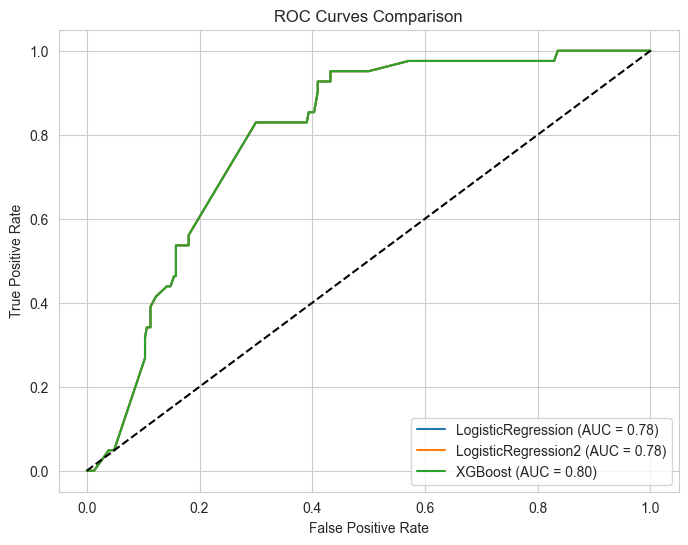

In [704]:
# 10. Plot ROC curves for all models
plt.figure(figsize=(8,6))
for r in results:
    # Use best estimator to get ROC values
    name = r['model']
    probas = search.best_estimator_.named_steps['clf'].predict_proba(
        search.best_estimator_.named_steps['preproc'].transform(X_test)
    )[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probas)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {r['roc_auc']:.2f})")

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend(loc='lower right')
plt.show()